# IMC breast cancer

In this notebook we demonstrate how mosna can be used to analyze spatiallly resolved omics data.  
The data used is from the publication by [Danenberg et al., Nature Genetics, 2023](https://doi.org/10.1038/s41588-022-01041-y) "Breast tumor microenvironment structures are associated with genomic features and clinical outcome".  
Here 693 tumors of breast cancer were processed with the [Imaging Mass Cytometry](https://doi.org/10.1038/s43018-020-0026-6) method (cytometry by time of fligh, CyTOF) to produce maps of 37 proteins and study the relationship between cell types in tumors with respect to survival.  

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs
from sklearn.impute import KNNImputer
from lifelines import KaplanMeierFitter, CoxPHFitter

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [3]:
RUN_LONG = True

### Objects data

Load files that contains all the detected objects (the cells) across all samples and clinical data.  
Data is available here: https://zenodo.org/records/7324285  
Images are available here: https://zenodo.org/records/6036188

In [4]:
data_dir = Path("../data/raw/IMC_Breast_cancer_Danenberg_2022")
objects_path = data_dir / "SingleCells.csv"

if objects_path.with_suffix('.parquet').exists():
    obj = pd.read_parquet(objects_path.with_suffix('.parquet'))
else:
    obj = pd.read_csv(objects_path)
    # for latter use
    obj.to_parquet(objects_path.with_suffix('.parquet'))
obj

ImageNumber  ObjectNumber metabric_id           cellPhenotype  \
0                  1             1     MB-0282         CK^{med}ER^{lo}   
1                  1             2     MB-0282       ER^{hi}CXCL12^{+}   
2                  1             4     MB-0282  CD4^{+} T cells & APCs   
3                  1             5     MB-0282         CK^{med}ER^{lo}   
4                  1             7     MB-0282         CD4^{+} T cells   
...              ...           ...         ...                     ...   
1123461          797          3818     MB-0406  CK8-18^{hi}CXCL12^{hi}   
1123462          797          3819     MB-0406  CK8-18^{hi}CXCL12^{hi}   
1123463          797          3820     MB-0406  CK8-18^{hi}CXCL12^{hi}   
1123464          797          3822     MB-0406          CK^{lo}ER^{lo}   
1123465          797          3823     MB-0406             Fibroblasts   

         is_epithelial  is_tumour  is_normal  is_dcis  is_interface  \
0                    1          1          0        0             1   
1                    1          1          0        0             1   
2                    0          1          0        0             0   
3                    1          1          0        0             0   
4                    0          1          0        0             1   
...                ...        ...        ...      ...           ...   
1123461              1          1          0        0             0   
1123462              1          1          0        0             0   
1123463              1          1          0        0             1   
1123464              1          1          0        0             1   
1123465              0          1          0        0             0   

         is_perivascular  ...  CD31-vWF    CXCL12   HLA-ABC      panCK  \
0                      0  ...  0.495330  0.401104  9.282180  18.180412   
1                      0  ...  0.552035  2.567602  1.417755  48.593726   
2                      0  ...  0.493669  0.117742  3.791699   3.404438   
3                      0  ...  0.373286  1.048929  2.364418  23.289196   
4                      0  ...  0.287512  0.058795  4.690886   0.664581   
...                  ...  ...       ...       ...       ...        ...   
1123461                0  ...  0.412993  7.255870  0.947830  76.300971   
1123462                0  ...  0.609522  3.370633  1.534348  53.953806   
1123463                0  ...  0.562381  2.553417  0.629895  41.573201   
1123464                0  ...  0.133439  0.019060  1.156061   0.053584   
1123465                0  ...  0.218254  0.054445  1.138097   0.333484   

         c-Caspase3       DNA1       DNA2  Location_Center_X  \
0          0.163026  29.445302  54.989698         121.418605   
1          0.310149  23.160734  42.596685         150.468531   
2          0.242591  16.884008  31.325295         221.930233   
3          0.297700   8.475436  15.654673         354.136364   
4          0.078051  14.009167  28.587826         469.174603   
...             ...        ...        ...                ...   
1123461    0.000000  16.235925  31.912625         482.950000   
1123462    0.205527   7.448000  12.347708         605.791667   
1123463    0.187847   9.222450  18.821950         833.200000   
1123464    0.000000   3.641944   7.286806         851.916667   
1123465    0.000000  10.869333  21.537233         748.466667   

         Location_Center_Y  AreaShape_Area  
0                 4.023256              43  
1                 6.083916             143  
2                 5.139535             129  
3                 5.890909             110  
4                 7.158730             126  
...                    ...             ...  
1123461         947.825000              40  
1123462         945.333333              24  
1123463         947.350000              20  
1123464         949.222222              36  
1123465         949.733333              30  

[1123466 rows x 53 columns]

`ObjectNumber` is the ID of cells, starting at 1 for each image (there are 797 ObjectNumber = 1).

In [5]:
obj.rename(columns={'Location_Center_X': 'x', 'Location_Center_Y': 'y'}, inplace=True)
sample_cols = ['ImageNumber', 'ObjectNumber', 'metabric_id']
# this file contains 'c-Caspase3c-PARP' instead of 'c-Caspase3c' as in the dataframe
# all_epitopes = pd.read_csv(data_dir / 'markerStackOrder.csv').iloc[:, 1].values
# so instead we directly do:
all_epitopes = obj.columns[11:50].values
# remove Histone H3 and DNA markers
marker_cols = list(all_epitopes[1:-2])
pos_cols = ['x', 'y']
cell_type_cols = [
    'is_epithelial',
    'is_tumour',
    'is_normal',
    'is_dcis',
    'is_interface',
    'is_perivascular',
    'is_hotAggregate',
    ]
sample_col = 'ImageNumber'  # != from `sample_cols`
patient_col = 'metabric_id'
pheno_col = 'cellPhenotype'
nb_phenotypes = obj[pheno_col].unique().size
all_cols = sample_cols + marker_cols + pos_cols + cell_type_cols + [pheno_col]
# columns we want to include in network data
net_cols = pos_cols + [pheno_col] + cell_type_cols + marker_cols

print(f'nb phenotypes: {nb_phenotypes}')
print(f'nb used markers: {len(marker_cols)}')

nb phenotypes: 32
nb used markers: 36


In [6]:
# # Load published network
# neighbs = pd.read_csv(data_dir / 'CellNeighbours.csv')

In [7]:
# Show number of cells per sample
sample_sizes = obj[['ImageNumber', 'ObjectNumber']].groupby(['ImageNumber']).count()
sample_sizes

ObjectNumber
ImageNumber              
1                    1624
2                    1057
3                    1648
4                    1348
5                    2018
...                   ...
793                   372
794                  4460
795                  2689
796                   737
797                  3758

[794 rows x 1 columns]

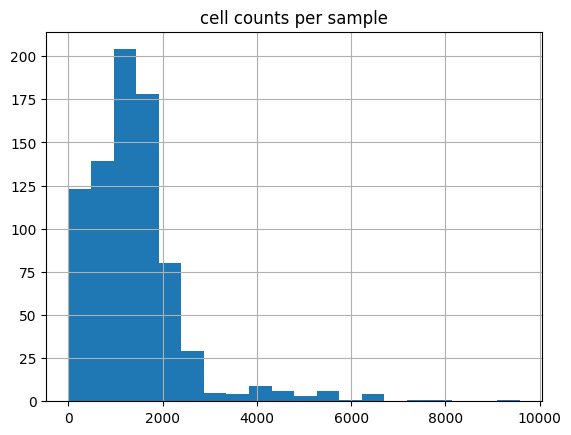

In [8]:
axes = sample_sizes.hist(bins=20)
axes[0][0].set_title('cell counts per sample');

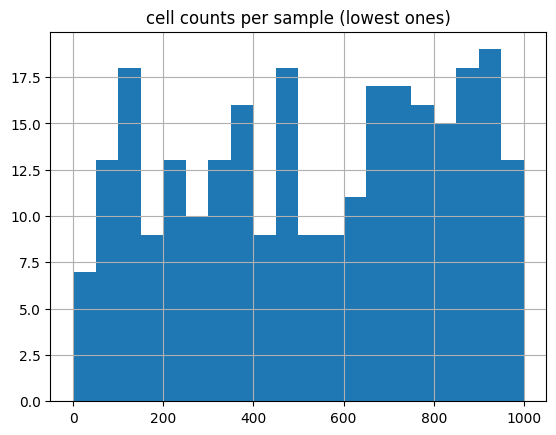

In [9]:
axes = sample_sizes.hist(bins=20, range=(0, 1000))
axes[0][0].set_title('cell counts per sample (lowest ones)');

We may need to discard patients with too few cells, we'll manually inspect reconstructed networks to define a size threshold latter in this notebook.

In [10]:
# aggregate unique pairs of patients and image IDs
sample_patient_counts = obj[sample_cols].groupby([sample_col, patient_col]).count()
print(sample_patient_counts)

# count occurrences of patient IDs in patient / image pairs
occ = sample_patient_counts.index.get_level_values(1).value_counts()
print(occ)

n_patient_multiple = np.sum(occ.values != 1)
print(f'There are {n_patient_multiple} patients with multiple samples')

sample_patient_mapper = dict(sample_patient_counts.index.values)

                         ObjectNumber
ImageNumber metabric_id              
1           MB-0282              1624
2           MB-0099              1057
3           MB-0598              1648
4           MB-0606              1348
5           MB-0190              2018
...                               ...
793         MB-0359               372
794         MB-0353              4460
795         MB-0158              2689
796         MB-0158               737
797         MB-0406              3758

[794 rows x 1 columns]
metabric_id
MB-0359    4
MB-0135    3
MB-0175    3
MB-0145    3
MB-0184    3
          ..
MB-0180    1
MB-0181    1
MB-0182    1
MB-0183    1
MB-0129    1
Name: count, Length: 718, dtype: int64
There are 59 patients with multiple samples


### Survival data

From the authors:
> Processed metadata from the METABRIC study are among the files provided.  It is, however, recommended that additional analyses that rely on METABRIC metadata, use data downloaded from their original publications or a public repository as these data are subject to updates, and the user may wish to process them differently.

In [11]:
survival_path = data_dir / "IMCClinical.csv"
surv = pd.read_csv(survival_path, index_col=0)
surv

ERStatus LymphNodesOrdinal sizeOrdinal  Grade ERBB2_pos  \
metabric_id                                                           
MB-0000          pos                7+     20-50mm    3.0     False   
MB-0002          pos                 0      5-10mm    3.0     False   
MB-0005          pos                 1     10-20mm    2.0     False   
MB-0006          pos               2-3     20-50mm    2.0     False   
MB-0008          pos                7+     20-50mm    3.0     False   
...              ...               ...         ...    ...       ...   
MB-3824          pos                 0     20-50mm    3.0     False   
MB-3838          pos                 0     20-50mm    3.0     False   
MB-3854          neg                 0     10-20mm    1.0     False   
MB-3876          neg                 0     20-50mm    3.0       NaN   
MB-3978          neg                 0     10-20mm    3.0      True   

             yearsToStatus  DeathBreast  isValidation        PAM50  \
metabric_id                                                          
MB-0000          11.540041            0         False  Normal-like   
MB-0002           6.951403            0         False    Luminal A   
MB-0005          13.445585            1         False    Luminal B   
MB-0006          13.546886            0         False    Luminal B   
MB-0008           3.397673            1         False    Luminal B   
...                    ...          ...           ...          ...   
MB-3824          10.387406            1          True    Luminal B   
MB-3838          11.044490            1          True    Luminal B   
MB-3854           8.150582            0          True    Luminal A   
MB-3876           1.612594            1         False          NaN   
MB-3978           8.284736            1          True         HER2   

                IntClust  
metabric_id               
MB-0000      IntClust 4+  
MB-0002      IntClust 4+  
MB-0005       IntClust 3  
MB-0006       IntClust 9  
MB-0008       IntClust 9  
...                  ...  
MB-3824       IntClust 2  
MB-3838       IntClust 8  
MB-3854       IntClust 3  
MB-3876              NaN  
MB-3978      IntClust 5-  

[709 rows x 10 columns]

### Discard small samples

In [14]:
trim_dist = 200
min_neighbors = 3
smallest_samples = sample_sizes.sort_values('ObjectNumber') #.head(20)

if RUN_LONG:
    for sample_name in smallest_samples.index[:100]:
        print("    processing sample {}".format(sample_name))
        select_sample = obj[sample_col] == sample_name
        nodes = obj.loc[select_sample, all_cols]
        coords = nodes[pos_cols].values
        pairs = ty.build_delaunay(
            coords, 
            node_adaptive_trimming=True, 
            n_edges=3, 
            trim_dist_ratio=2,
            min_dist=0, 
            trim_dist=trim_dist,
            )
        print("    ", end="")

        if min_neighbors > 0:
            pairs = ty.link_solitaries(
                coords, 
                pairs, 
                min_neighbors=min_neighbors,
                )
        distances = ty.distance_neighbors(coords, pairs)

        sample_size = len(coords)
        fig, ax = ty.plot_network(
            coords, pairs, labels=nodes[pheno_col],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.2, 0.5)}
            )
        plt.axis('off');
        title = f"network_sample-{sample_name}"
        ax.set_title(f"sample: {sample_name}   size: {sample_size}")
        plt.show()

We discard samples with less than 150 cells.

In [12]:
net_size_threshold = 150

select = sample_sizes['ObjectNumber'] >= net_size_threshold
print(f"there are {select.sum()} samples with > {net_size_threshold} cells, disarding {len(select) - select.sum()} samples")
sample_sizes = sample_sizes.loc[select, :]
uniq_samples = sample_sizes.index.values

print(f"filtering small samples, full dataframe dropping from {len(obj)} cells to", end=' ')
obj = obj.query("ImageNumber in @uniq_samples")
print(f'{len(obj)} cells')

print(f"survival data dropping from {len(surv)} patients to", end=' ')
uniq_patients = obj['metabric_id'].unique()
surv = surv.query("metabric_id in @uniq_patients")
print(f'{len(surv)} patients')

there are 756 samples with > 150 cells, disarding 38 samples
filtering small samples, full dataframe dropping from 1123466 cells to 1120100 cells
survival data dropping from 709 patients to 672 patients


## Spatial networks reconstruction

### Load one sample

We will have a look at the spatial networks of different samples from the same patient to check they seem "correct", i.e. not over nor under connected.

In [13]:
# make common color mapper
cycle_cmap = False

nodes_labels = obj[pheno_col]
uniq = pd.Series(nodes_labels).value_counts().index

if nodes_labels is not None:
    nb_clust = nodes_labels.max()
    uniq = pd.Series(nodes_labels).value_counts().index

    # choose colormap
    clusters_cmap = mosna.make_cluster_cmap(uniq)
    # make color mapper
    # series to sort by decreasing order
    n_colors = len(clusters_cmap)
    celltypes_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}

processing sample 59
there are 1/301 nodes with < 3 edges
processing sample 150
there are 2/1060 nodes with < 3 edges
processing sample 790
there are 4/3598 nodes with < 3 edges
processing sample 793
there are 4/372 nodes with < 3 edges


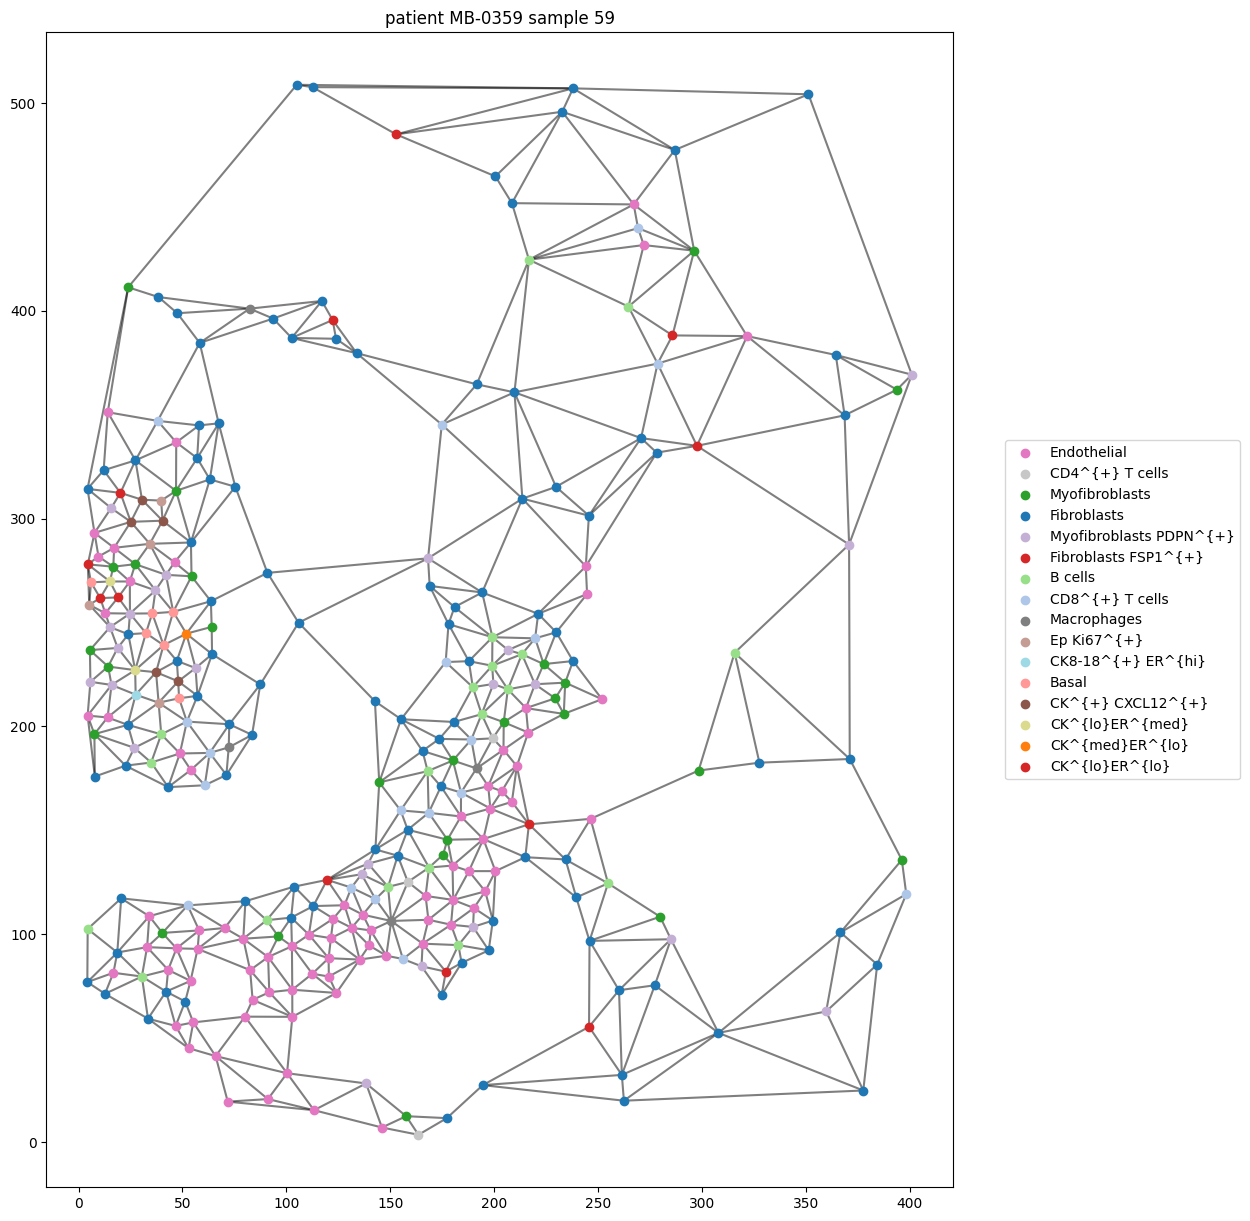

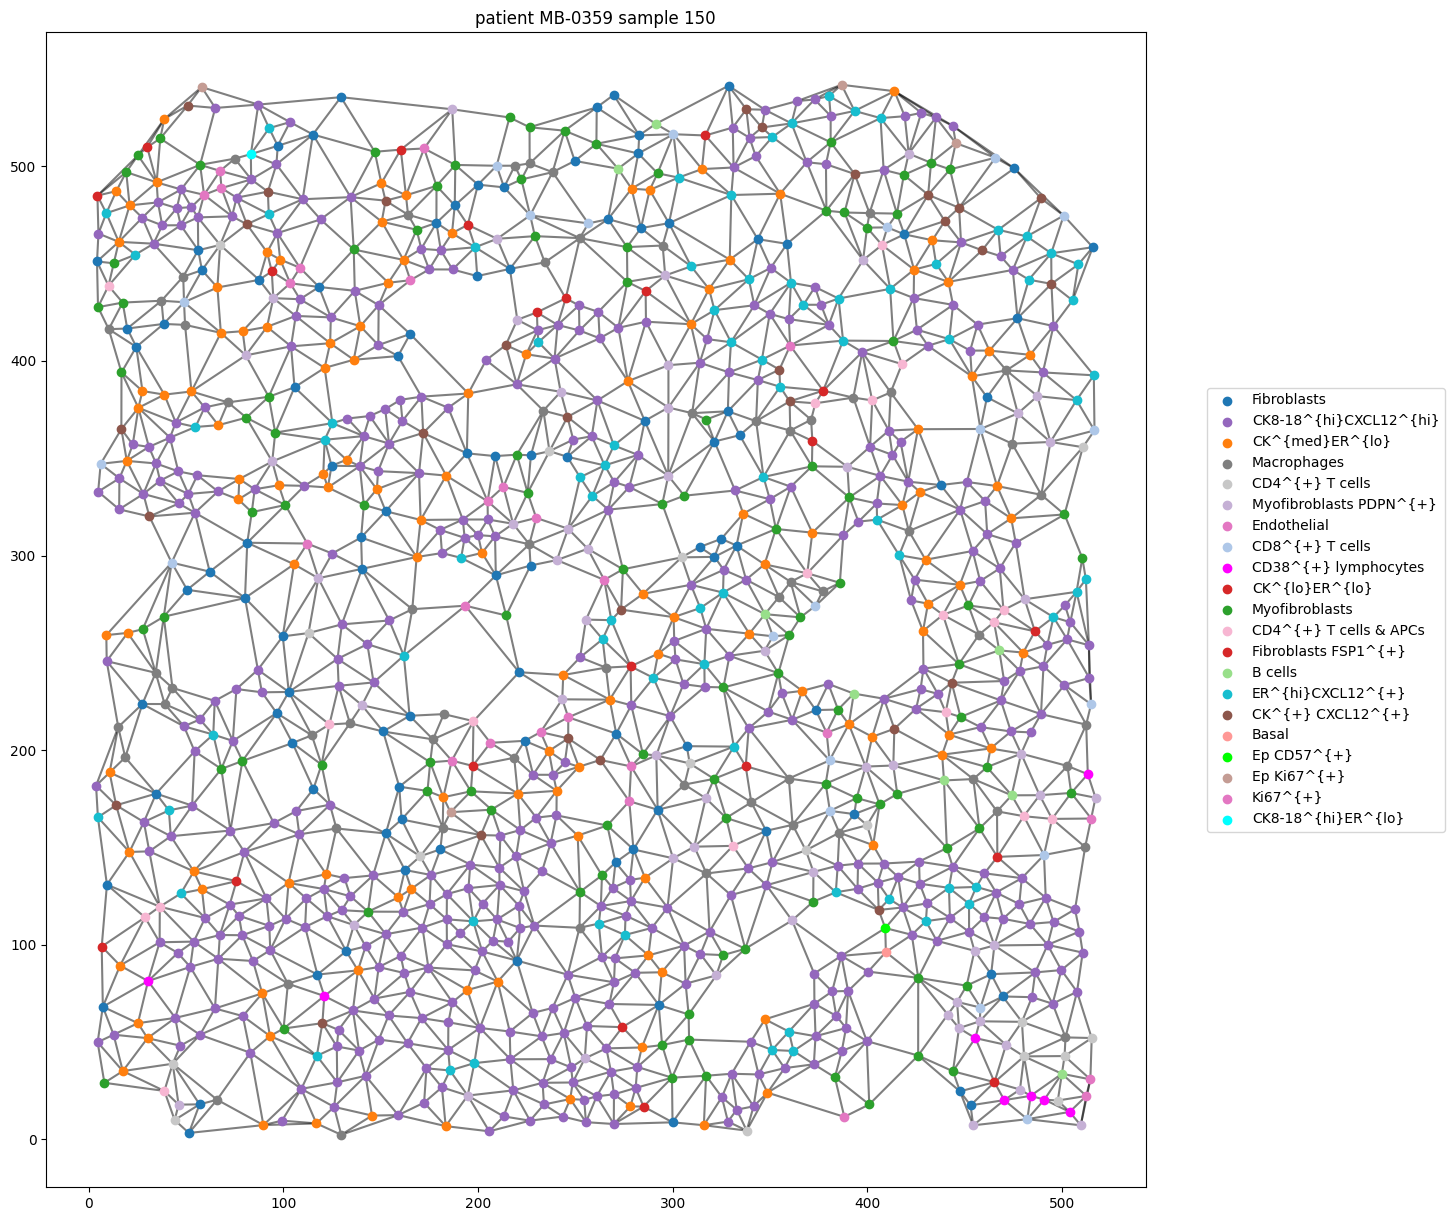

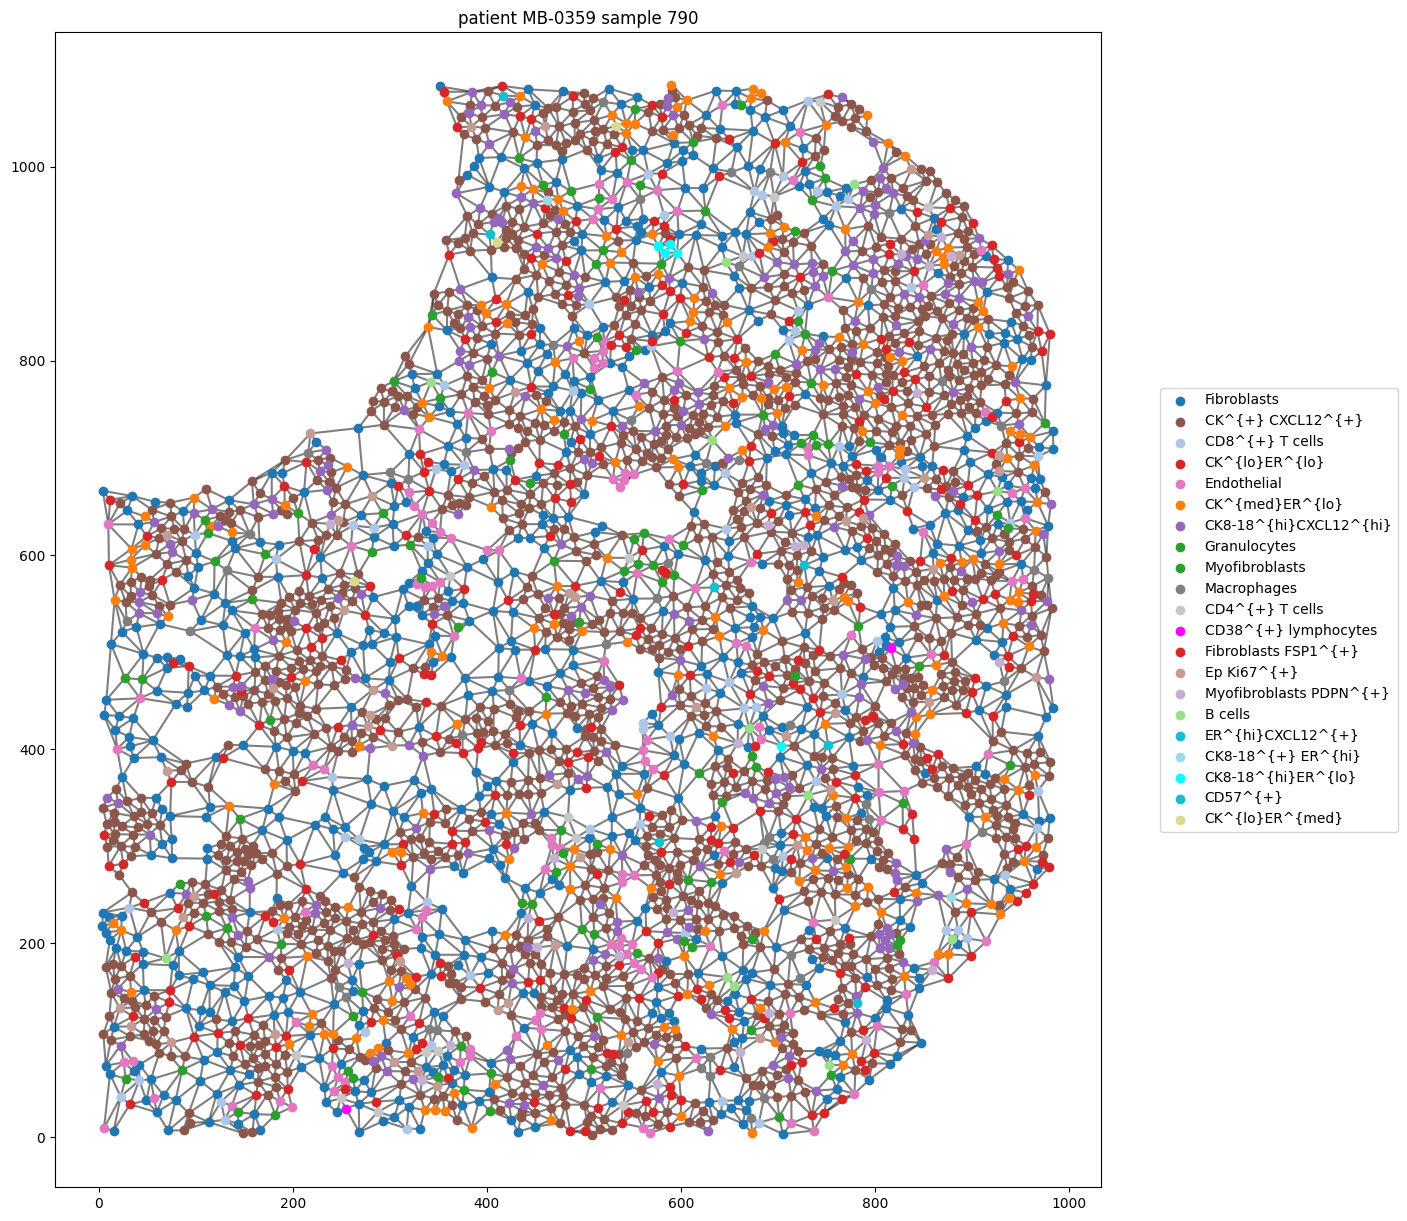

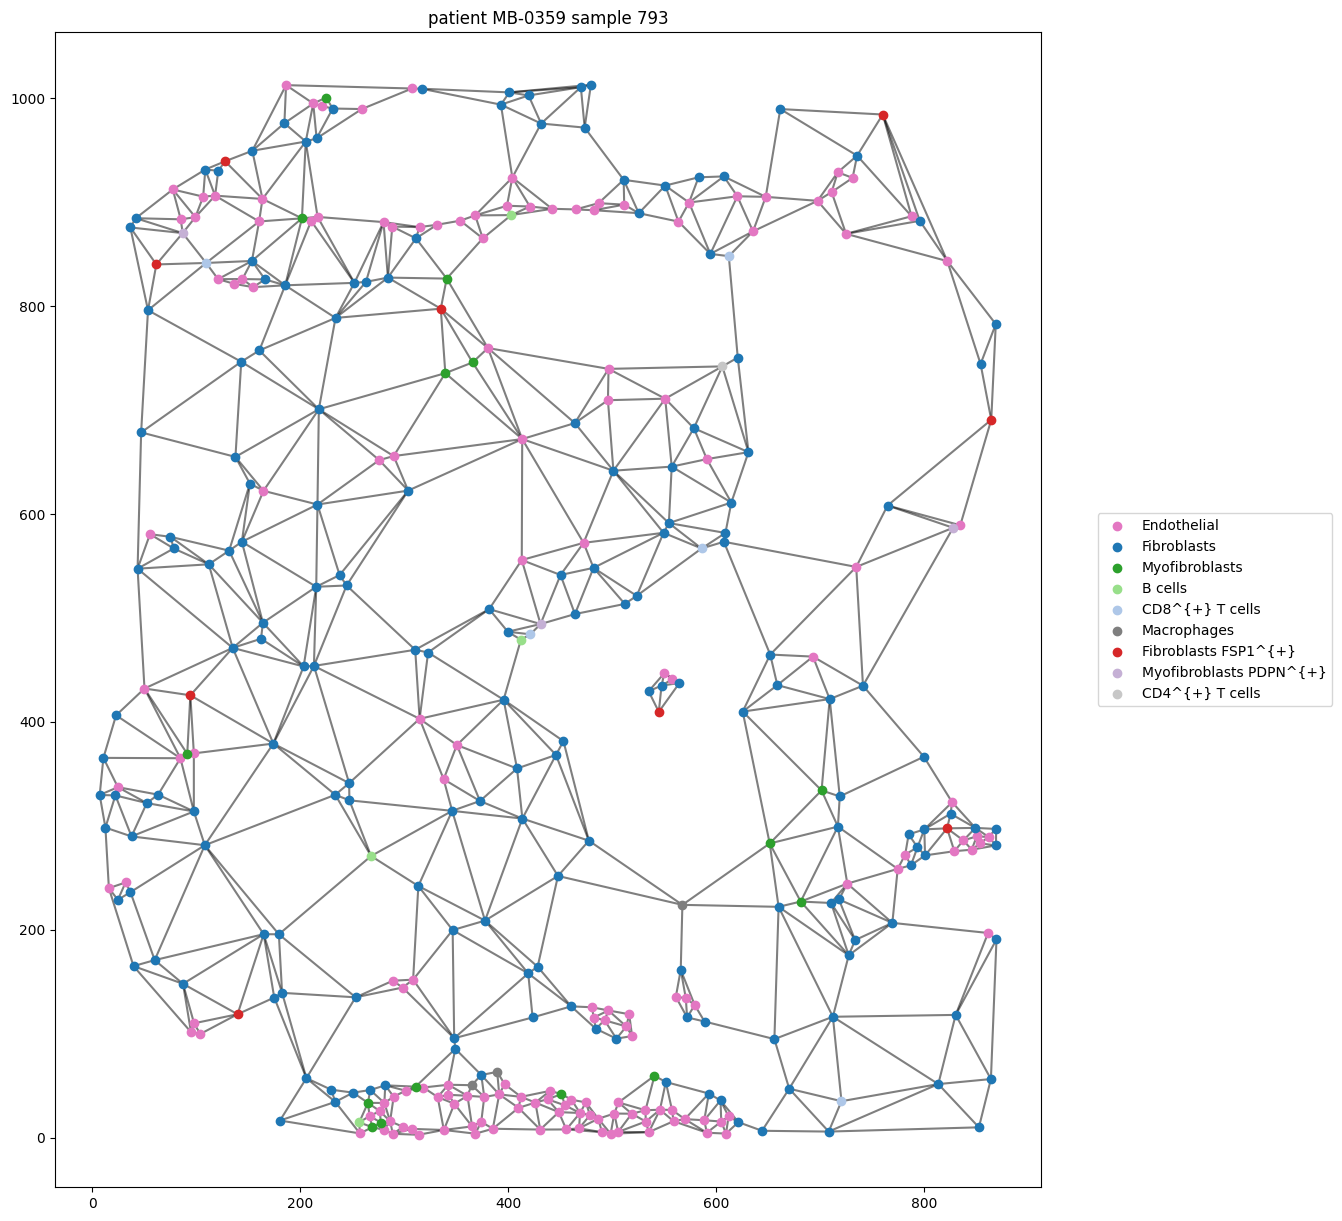

In [14]:
patient_id = 'MB-0359'  # this person has 4 samples
select_patient = obj[patient_col] == patient_id
sample_names = obj.loc[select_patient, sample_col].unique()  # look for the several samples per patient
for sample_name in sample_names:
    print("processing sample {}".format(sample_name))
    select_sample = obj[sample_col] == sample_name
    nodes = obj.loc[select_patient & select_sample, net_cols]
    coords = nodes[pos_cols].values
    pairs = ty.build_delaunay(coords)
    # we want to avoid isolated cells, so we link them to their 3 closest neighbors
    pairs = ty.link_solitaries(coords, pairs, method='delaunay', min_neighbors=3)

    fig, ax = ty.plot_network(
        coords, pairs, labels=nodes[pheno_col],
        color_mapper=celltypes_color_mapper, 
        legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)},
        )
    plt.title("patient {} sample {}".format(patient_id, sample_name))

### All samples network reconstruction

#### Plot spatial networks

In [14]:
processed_dir = Path('../data/processed/IMC_breast_cancer')
dir_fig_save = processed_dir / 'figures'

In [18]:
# Choose optimal distance threshold for edge trimming

trim_dist = 200 # or 'percentile_size'
min_neighbors = 3 # number of nearest nodes to connect for each unconneted node

save_dir = processed_dir / f"samples_networks_xy_choose_distance_trim_dist-{trim_dist}_solitary-{min_neighbors}"
save_dir.mkdir(parents=True, exist_ok=True)

# use few networks
samples_dst = obj[sample_col].unique()[:10]

if RUN_LONG:
    for sample_name in samples_dst:
        print("    processing sample {}".format(sample_name))
        select_sample = obj[sample_col] == sample_name
        nodes = obj.loc[select_sample, all_cols]
        coords = nodes[pos_cols].values
        pairs = ty.build_delaunay(
            coords, 
            node_adaptive_trimming=True, 
            n_edges=3, 
            trim_dist_ratio=2,
            min_dist=0, 
            trim_dist=trim_dist,
            )
        print("    ", end="")

        if min_neighbors > 0:
            pairs = ty.link_solitaries(
                coords, 
                pairs, 
                min_neighbors=min_neighbors,
                )
        distances = ty.distance_neighbors(coords, pairs)

        fig, ax = ty.plot_network_distances(
            coords, pairs, distances, labels=nodes[pheno_col],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.2, 0.5)}
            )
        plt.axis('off');
        title = f"network_distances_sample-{sample_name}"
        plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
        plt.show()

In [15]:
trim_dist = 200 # or 'percentile_size'
min_neighbors = 3 # number of nearest nodes to connect for each unconneted node

reconst_dir = processed_dir / f"samples_networks_xy_min_size-{net_size_threshold}_solitary-{min_neighbors}"
save_dir = reconst_dir / "networks_images_common_cmap_saturated_first"
save_dir.mkdir(parents=True, exist_ok=True)

In [20]:
if RUN_LONG:
    # avoid displaying networks in notebook and using more memory
    plt.ioff()
    for i, patient_id in enumerate(uniq_patients):
        print(f"processing patient {patient_id} {i}/{len(uniq_patients)}")
        select_patient = obj[patient_col] == patient_id
        samples = obj.loc[select_patient, sample_col].unique()
        for sample in samples:
            print(f"    processing sample {sample}")
            select_sample = obj[sample_col] == sample
            nodes = obj.loc[select_patient & select_sample, all_cols]
            coords = nodes[pos_cols].values
            pairs = ty.build_delaunay(
                coords, 
                node_adaptive_trimming=True, 
                n_edges=3, 
                trim_dist_ratio=2,
                min_dist=0, 
                trim_dist=trim_dist,
                )
            
            if min_neighbors > 0:
                pairs = ty.link_solitaries(
                    coords, 
                    pairs, 
                    min_neighbors=min_neighbors,
                    )

            fig, ax = ty.plot_network(coords, pairs, labels=nodes[pheno_col],
                                      color_mapper=celltypes_color_mapper, 
                                      legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"patient-{patient_id}_sample-{sample}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            # plt.show()
            plt.close(fig)
    plt.ion()

#### Merge all samples

In [16]:
n_uniq_patients = len(uniq_patients)
n_uniq_samples = len(uniq_samples)

In [147]:
obj[[sample_col, patient_col]].value_counts()

ImageNumber  metabric_id
743          MB-0269        9576
792          MB-0317        7860
758          MB-0149        7359
751          MB-0325        6602
764          MB-0473        6466
                            ... 
512          MB-0634         160
554          MB-2613         159
328          MB-0645         157
673          MB-3252         155
130          MB-0913         155
Name: count, Length: 756, dtype: int64

In [142]:
sample_patient_mapper = {}
for patient_id in uniq_patients:
    select_patient = obj[patient_col] == patient_id
    samples = obj.loc[select_patient, sample_col].unique()
    for sample in samples:
        sample_patient_mapper[sample] = patient_id

In [22]:
# save networks in separate files
if RUN_LONG:
    for i, patient_id in enumerate(uniq_patients):
        print(f"processing patient {patient_id} {i}/{n_uniq_patients}")
        select_patient = obj[patient_col] == patient_id
        samples = obj.loc[select_patient, sample_col].unique()
        for j, sample in enumerate(samples):
            print(f"    processing sample {sample} {i+j}/{n_uniq_samples}")
            select_sample = obj[sample_col] == sample
            nodes = obj.loc[select_patient & select_sample, :]
            coords = nodes[pos_cols].values
            pairs = ty.build_delaunay(
                coords, 
                node_adaptive_trimming=True, 
                n_edges=3, 
                trim_dist_ratio=2,
                min_dist=0, 
                trim_dist=trim_dist,
                )
            
            if min_neighbors > 0:
                pairs = ty.link_solitaries(
                    coords, 
                    pairs, 
                    min_neighbors=min_neighbors,
                    verbose=0,
                    )

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_parquet(reconst_dir / f'edges_patient-{patient_id}_sample-{sample}.parquet', index=False)

            nodes.to_parquet(reconst_dir / f'nodes_patient-{patient_id}_sample-{sample}.parquet', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, or "niches", potentially predictive of response to therapy.

### Cell types proportions

In [17]:
# we add attributes to nodes to color network figures
nodes_all = obj[pos_cols + [pheno_col]].copy()
nodes_all = nodes_all.join(pd.get_dummies(obj[pheno_col]))
uniq_phenotypes = nodes_all[pheno_col].unique()  # 'attribute_uniq' in other notebooks

In [18]:
# here we don't use `sample_col` but `patient_col` in the group / unstack procedure to aggregate 
# statistics per patient and condition rather than per sample.

count_types = obj[[patient_col, pheno_col, sample_col]].groupby([patient_col, pheno_col]).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient.csv')
count_types

cellPhenotype  B cells  Basal  CD15^{+}  CD38^{+} lymphocytes  \
metabric_id                                                     
MB-0000              1      0         0                     0   
MB-0002              0      0         1                     0   
MB-0005              1      0       706                     0   
MB-0006              1     17         0                     5   
MB-0010              1      0         2                     6   
...                ...    ...       ...                   ...   
MB-3824              3      1        20                     3   
MB-3838              0      0       130                     0   
MB-3854              0      1        85                     0   
MB-3876             17      1         9                     4   
MB-3978              5     57       172                     2   

cellPhenotype  CD4^{+} T cells  CD4^{+} T cells & APCs  CD57^{+}  \
metabric_id                                                        
MB-0000                      0                       0         0   
MB-0002                      2                       0         0   
MB-0005                      0                       0         0   
MB-0006                      4                       0         0   
MB-0010                     13                       5         0   
...                        ...                     ...       ...   
MB-3824                      5                       0         0   
MB-3838                      1                       0         2   
MB-3854                     11                       0         0   
MB-3876                      6                      82         0   
MB-3978                     53                       1         0   

cellPhenotype  CD8^{+} T cells  CK8-18^{+} ER^{hi}  CK8-18^{hi}CXCL12^{hi}  \
metabric_id                                                                  
MB-0000                      4                   1                      10   
MB-0002                      7                   0                     892   
MB-0005                     11                   1                      19   
MB-0006                      4                   0                      94   
MB-0010                      8                1018                       0   
...                        ...                 ...                     ...   
MB-3824                      1                   0                       3   
MB-3838                      9                   0                      14   
MB-3854                     15                   1                       7   
MB-3876                     95                   0                       8   
MB-3978                     76                   0                       0   

cellPhenotype  ...  HER2^{+}  Ki67^{+}  MHC I & II^{hi}  MHC I^{hi}CD57^{+}  \
metabric_id    ...                                                            
MB-0000        ...         0         0                0                   0   
MB-0002        ...         0         0                0                   0   
MB-0005        ...         3         0                0                   0   
MB-0006        ...         0         0                0                   0   
MB-0010        ...         0         3                7                   1   
...            ...       ...       ...              ...                 ...   
MB-3824        ...         1         0                0                   0   
MB-3838        ...         0         0                0                   0   
MB-3854        ...         0         0                0                   0   
MB-3876        ...        75         2               46                   0   
MB-3978        ...       304         0                3                   0   

cellPhenotype  MHC^{hi}CD15^{+}  Macrophages  Macrophages & granulocytes  \
metabric_id                                                                
MB-0000                       0            3                           0  

Instead of counts we use proportions of cell types per patient and condition.

In [19]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

cellPhenotype   B cells     Basal  CD15^{+}  CD38^{+} lymphocytes  \
metabric_id                                                         
MB-0000        0.003968  0.000000  0.000000              0.000000   
MB-0002        0.000000  0.000000  0.000473              0.000000   
MB-0005        0.000641  0.000000  0.452854              0.000000   
MB-0006        0.001235  0.020988  0.000000              0.006173   
MB-0010        0.000716  0.000000  0.001433              0.004298   
...                 ...       ...       ...                   ...   
MB-3824        0.005736  0.001912  0.038241              0.005736   
MB-3838        0.000000  0.000000  0.275424              0.000000   
MB-3854        0.000000  0.002342  0.199063              0.000000   
MB-3876        0.014120  0.000831  0.007475              0.003322   
MB-3978        0.003514  0.040056  0.120871              0.001405   

cellPhenotype  CD4^{+} T cells  CD4^{+} T cells & APCs  CD57^{+}  \
metabric_id                                                        
MB-0000               0.000000                0.000000  0.000000   
MB-0002               0.000946                0.000000  0.000000   
MB-0005               0.000000                0.000000  0.000000   
MB-0006               0.004938                0.000000  0.000000   
MB-0010               0.009312                0.003582  0.000000   
...                        ...                     ...       ...   
MB-3824               0.009560                0.000000  0.000000   
MB-3838               0.002119                0.000000  0.004237   
MB-3854               0.025761                0.000000  0.000000   
MB-3876               0.004983                0.068106  0.000000   
MB-3978               0.037245                0.000703  0.000000   

cellPhenotype  CD8^{+} T cells  CK8-18^{+} ER^{hi}  CK8-18^{hi}CXCL12^{hi}  \
metabric_id                                                                  
MB-0000               0.015873            0.003968                0.039683   
MB-0002               0.003310            0.000000                0.421749   
MB-0005               0.007056            0.000641                0.012187   
MB-0006               0.004938            0.000000                0.116049   
MB-0010               0.005731            0.729226                0.000000   
...                        ...                 ...                     ...   
MB-3824               0.001912            0.000000                0.005736   
MB-3838               0.019068            0.000000                0.029661   
MB-3854               0.035129            0.002342                0.016393   
MB-3876               0.078904            0.000000                0.006645   
MB-3978               0.053408            0.000000                0.000000   

cellPhenotype  ...  HER2^{+}  Ki67^{+}  MHC I & II^{hi}  MHC I^{hi}CD57^{+}  \
metabric_id    ...                                                            
MB-0000        ...  0.000000  0.000000         0.000000            0.000000   
MB-0002        ...  0.000000  0.000000         0.000000            0.000000   
MB-0005        ...  0.001924  0.000000         0.000000            0.000000   
MB-0006        ...  0.000000  0.000000         0.000000            0.000000   
MB-0010        ...  0.000000  0.002149         0.005014            0.000716   
...            ...       ...       ...              ...                 ...   
MB-3824        ...  0.001912  0.000000         0.000000            0.000000   
MB-3838        ...  0.000000  0.000000         0.000000            0.000000   
MB-3854        ...  0.000000  0.000000         0.000000            0.000000   
MB-3876        ...  0.062292  0.001661         0.038206            0.000000   
MB-3978        ...  0.213633  0.000000         0.002108            0.000000   

cellPhenotype  MHC^{hi}CD15^{+}  Macrophages  Macrophages & granulocytes  \
metabric_id                                                                
MB-0000               

In [20]:
surv_orig = surv.copy()
surv = surv.loc[~surv['isValidation'], :]
surv.drop(columns=['isValidation'], inplace=True)

In [21]:
surv

ERStatus LymphNodesOrdinal sizeOrdinal  Grade ERBB2_pos  \
metabric_id                                                           
MB-0000          pos                7+     20-50mm    3.0     False   
MB-0002          pos                 0      5-10mm    3.0     False   
MB-0005          pos                 1     10-20mm    2.0     False   
MB-0006          pos               2-3     20-50mm    2.0     False   
MB-0010          pos                 0     20-50mm    3.0     False   
...              ...               ...         ...    ...       ...   
MB-3688          pos                 0     20-50mm    3.0       NaN   
MB-3692          pos                 1     20-50mm    3.0       NaN   
MB-3747          pos                 0     20-50mm    2.0       NaN   
MB-3804          neg                 0     20-50mm    3.0       NaN   
MB-3876          neg                 0     20-50mm    3.0       NaN   

             yearsToStatus  DeathBreast        PAM50     IntClust  
metabric_id                                                        
MB-0000          11.540041            0  Normal-like  IntClust 4+  
MB-0002           6.951403            0    Luminal A  IntClust 4+  
MB-0005          13.445585            1    Luminal B   IntClust 3  
MB-0006          13.546886            0    Luminal B   IntClust 9  
MB-0010           0.640657            1    Luminal B   IntClust 7  
...                    ...          ...          ...          ...  
MB-3688           2.179329            1          NaN          NaN  
MB-3692           5.089665            1          NaN          NaN  
MB-3747          18.877481            0          NaN          NaN  
MB-3804          18.754278            0          NaN          NaN  
MB-3876           1.612594            1          NaN          NaN  

[509 rows x 9 columns]

In [22]:
# replace some values with numbers for fitting
mapper_str = {
    'pos': 1,
    'neg': 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERStatus'] = surv['ERStatus'].map(mapper_str)

mapper_bool = {
    True: 1,
    False: 0,
    np.nan: np.nan,
}
surv.loc[:, 'ERBB2_pos'] = surv['ERBB2_pos'].map(mapper_bool)

In [30]:
duration_col = 'yearsToStatus'
event_col = 'DeathBreast'
covariates = ['ERStatus'] #, 'ERBB2_pos'] # else []
strata = 'ERStatus'
drop_last_column = True   # because we use proportions last column is fully determined
drop_nan = True
if drop_last_column:
    df_surv = prop_types.iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = prop_types.join(surv[[duration_col, event_col] + covariates], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

discarded 15 / 509 observations with NaN


In [108]:
df_surv

B cells     Basal  CD15^{+}  CD38^{+} lymphocytes  \
metabric_id                                                       
MB-0000      0.003968  0.000000  0.000000              0.000000   
MB-0002      0.000000  0.000000  0.000473              0.000000   
MB-0005      0.000641  0.000000  0.452854              0.000000   
MB-0006      0.001235  0.020988  0.000000              0.006173   
MB-0010      0.000716  0.000000  0.001433              0.004298   
...               ...       ...       ...                   ...   
MB-3688      0.000429  0.002575  0.000858              0.000000   
MB-3692      0.019431  0.000000  0.006161              0.155450   
MB-3747      0.000000  0.000000  0.000000              0.000000   
MB-3804      0.003630  0.012704  0.062613              0.005445   
MB-3876      0.014120  0.000831  0.007475              0.003322   

             CD4^{+} T cells  CD4^{+} T cells & APCs  CD57^{+}  \
metabric_id                                                      
MB-0000             0.000000                0.000000       0.0   
MB-0002             0.000946                0.000000       0.0   
MB-0005             0.000000                0.000000       0.0   
MB-0006             0.004938                0.000000       0.0   
MB-0010             0.009312                0.003582       0.0   
...                      ...                     ...       ...   
MB-3688             0.014163                0.008155       0.0   
MB-3692             0.009953                0.099052       0.0   
MB-3747             0.000808                0.000000       0.0   
MB-3804             0.004537                0.024501       0.0   
MB-3876             0.004983                0.068106       0.0   

             CD8^{+} T cells  CK8-18^{+} ER^{hi}  CK8-18^{hi}CXCL12^{hi}  ...  \
metabric_id                                                               ...   
MB-0000             0.015873            0.003968                0.039683  ...   
MB-0002             0.003310            0.000000                0.421749  ...   
MB-0005             0.007056            0.000641                0.012187  ...   
MB-0006             0.004938            0.000000                0.116049  ...   
MB-0010             0.005731            0.729226                0.000000  ...   
...                      ...                 ...                     ...  ...   
MB-3688             0.014592            0.000000                0.000000  ...   
MB-3692             0.059242            0.000000                0.027488  ...   
MB-3747             0.012126            0.000000                0.383994  ...   
MB-3804             0.014519            0.000000                0.000000  ...   
MB-3876             0.078904            0.000000                0.006645  ...   

             MHC I & II^{hi}  MHC I^{hi}CD57^{+}  MHC^{hi}CD15^{+}  \
metabric_id                                                          
MB-0000             0.000000            0.000000          0.000000   
MB-0002             0.000000            0.000000          0.000000   
MB-0005             0.000000            0.000000          0.000000   
MB-0006             0.000000            0.000000          0.000000   
MB-0010             0.005014            0.000716          0.000000   
...                      ...                 ...               ...   
MB-3688             0.001717            0.000000          0.000000   
MB-3692             0.011848            0.000948          0.000948   
MB-3747             0.000000            0.000000          0.000000   
MB-3804             0.001815            0.000000          0.000000   
MB-3876             0.038206            0.000000          0.001661   

             Macrophages  Macrophages & granulocytes  Myofibroblasts  \
metabric_id                                                            
MB-0000         0.011905                    0.000000        0.015873   
MB-0002         0.003783                    0.000000        0.135697   
MB-0005         0.005131      

In [109]:
cph = CoxPHFitter(penalizer=0.0001)
if strata is None:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col)
else:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=strata)

# if convergence fails, use CoxPHFitter(penalizer=0.1).fit(…)
cph.print_summary()

/home/alexis/.pyenv/versions/3.10.13/envs/mosna/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Fibroblasts FSP1^{+}', 'Ki67^{+}'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 494 total observations, 339 right-censored observations>
             duration col = 'yearsToStatus'
                event col = 'DeathBreast'
                penalizer = 0.0001
                 l1 ratio = 0.0
                   strata = ERStatus
      baseline estimation = breslow
   number of observations = 494
number of events observed = 155
   partial log-likelihood = -756.55
         time fit was run = 2024-02-26 13:08:35 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
B cells                     -1.60      0.20      6.92          -15.17           11.96                0.00            1.57e+05
Basal                       -0.52      0.59      6.65          -13.56           12.51                0.00            2.72e+05
CD15^{+}                     1.13      3.08      6.55          -11.71           13.97                0.00            1.16e+06
CD38^{+} lymphocytes        -2.72      0.07      7.63          -17.68           12.24                0.00            2.06e+05
CD4^{+} T cells             -3.37      0.03      9.22          -21.44           14.70                0.00            2.42e+06
CD4^{+} T cells & APCs       4.97    144.54      8.58          -11.84           21.79                0.00            2.91e+09
CD57^{+}                     1.96      7.13      6.66          -11.09           15.02                0.00            3.32e+06
CD8^{+} T cells              0.68      1.98      7.78          -14.57           15.93                0.00            8.32e+06
CK8-18^{+} ER^{hi}           2.27      9.66      6.61          -10.69           15.23                0.00            4.10e+06
CK8-18^{hi}CXCL12^{hi}       0.63      1.88      6.56          -12.22           13.48                0.00            7.17e+05
CK8-18^{hi}ER^{lo}          -3.11      0.04      7.57          -17.95           11.74                0.00            1.25e+05
CK^{+} CXCL12^{+}           -0.14      0.87      6.66          -13.19           12.91                0.00            4.03e+05
CK^{lo}ER^{lo}              -0.14      0.87      6.63          -13.15           12.86                0.00            3.84e+05
CK^{lo}ER^{med}              2.11      8.24      6.63          -10.89           15.11                0.00            3.65e+06
CK^{med}ER^{lo}              1.12      3.07      6.54          -11.69           13.93                0.00            1.12e+06
ER^{hi}CXCL12^{+}            0.31      1.36      6.59          -12.61           13.22                0.00            5.53e+05
Endothelial                 -1.71      0.18      6.74          -14.92           11.51                0.00            99856.20
Ep CD57^{+}                  3.24     25.59      6.65           -9.79           16.28                0.00            1.17e+07
Ep Ki67^{+}                  3.39     29.60      6.69           -9.73           16.50                0.00            1.47e+07
Fibroblasts                  0.72      2.06      6.56          -12.13           13.57                0.00            7.84e+05
Fibroblasts FSP1^{+}       -33.63      0.00     19.58          -72.00            4.74                0.00              114.69
Granulocytes                 3.34     28.30      6.76           -9.90           16.59                0.00            1.60e+07
HER2^{+}                     2.16      8.65      6.59          -10.77           15.08                0.00            3.54e+06
Ki67^{+}                     2.56     12.96     27.60          -51.53           56.66                0.00            4.04e+24
MHC I & II^{hi}             -1.06      0.35      8.12          -16.97           14.86                0.00            2.84e+06
MHC I^{hi}CD57^{+}         -49.98      0.00     61.79         -171.09           71.13                0.00            7.78e

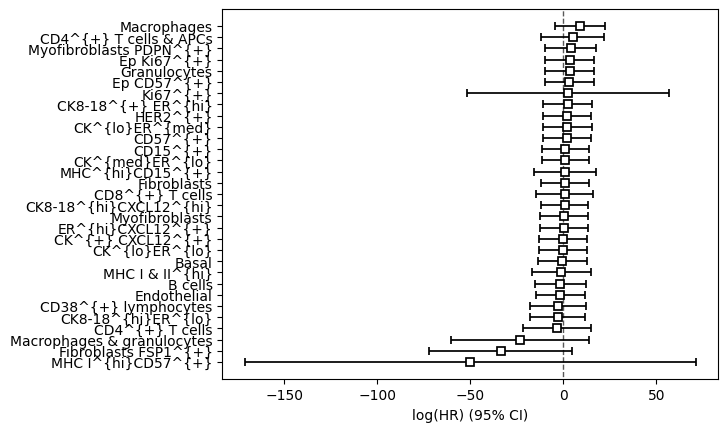

In [110]:
cph.plot();

<Axes: >

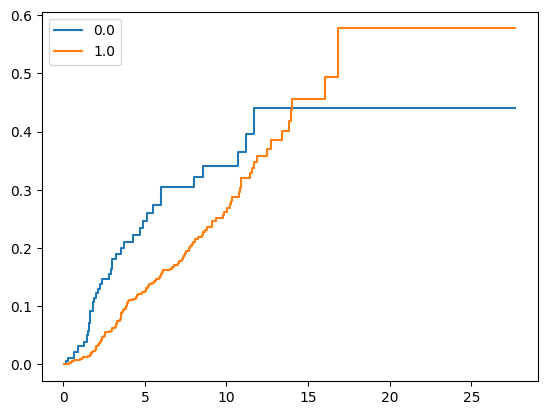

In [111]:
cph.baseline_cumulative_hazard_.plot(drawstyle="steps")

Try if better convergence by dropping low variance columns will help

In [112]:
col_exclude = ['Fibroblasts FSP1^{+}', 'Ki67^{+}']
use_cols = [x for x in prop_types.columns if x not in col_exclude]

drop_last_column = False   # we have already dropped some columns
drop_nan = True
if drop_last_column:
    df_surv = prop_types[use_cols].iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = prop_types[use_cols].join(surv[[duration_col, event_col] + covariates], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

discarded 15 / 509 observations with NaN


In [113]:
# cph = CoxPHFitter()  # convergence warnings
cph = CoxPHFitter(penalizer=0.0001)  # solves the issue
if strata is None:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col)
else:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=strata)
# but changing step_size doesn't solve the convergence issue:
# cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=['ERStatus'], 
#         fit_options={'step_size': 0.50})

# if convergence fails, use CoxPHFitter(penalizer=0.1).fit(…)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 494 total observations, 339 right-censored observations>
             duration col = 'yearsToStatus'
                event col = 'DeathBreast'
                penalizer = 0.0001
                 l1 ratio = 0.0
                   strata = ERStatus
      baseline estimation = breslow
   number of observations = 494
number of events observed = 155
   partial log-likelihood = -757.96
         time fit was run = 2024-02-26 13:08:36 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
B cells                      7.54   1879.67      8.50           -9.11           24.19                0.00            3.20e+10
Basal                        8.62   5566.53      8.39           -7.83           25.08                0.00            7.77e+10
CD15^{+}                    10.29  29470.10      8.38           -6.13           26.71                0.00            4.00e+11
CD38^{+} lymphocytes         6.92   1017.09      9.25          -11.20           25.05                0.00            7.55e+10
CD4^{+} T cells              6.77    869.23     11.20          -15.19           28.72                0.00            2.98e+12
CD4^{+} T cells & APCs      15.12  3.67e+06      9.14           -2.79           33.03                0.06            2.20e+14
CD57^{+}                    11.18  71474.82      8.41           -5.31           27.67                0.00            1.04e+12
CD8^{+} T cells              9.94  20750.72      8.73           -7.16           27.04                0.00            5.55e+11
CK8-18^{+} ER^{hi}          11.25  76746.68      8.48           -5.36           27.86                0.00            1.26e+12
CK8-18^{hi}CXCL12^{hi}       9.75  17105.92      8.42           -6.76           26.25                0.00            2.51e+11
CK8-18^{hi}ER^{lo}           6.78    876.53      8.85          -10.56           24.11                0.00            2.97e+10
CK^{+} CXCL12^{+}            9.07   8664.58      8.41           -7.42           25.56                0.00            1.26e+11
CK^{lo}ER^{lo}               9.07   8733.49      8.35           -7.28           25.43                0.00            1.11e+11
CK^{lo}ER^{med}             11.28  79129.54      8.45           -5.28           27.84                0.01            1.23e+12
CK^{med}ER^{lo}             10.35  31163.83      8.37           -6.06           26.75                0.00            4.15e+11
ER^{hi}CXCL12^{+}            9.50  13305.55      8.39           -6.96           25.95                0.00            1.86e+11
Endothelial                  7.12   1241.04      8.64           -9.82           24.07                0.00            2.83e+10
Ep CD57^{+}                 12.52  2.72e+05      8.40           -3.95           28.98                0.02            3.86e+12
Ep Ki67^{+}                 12.26  2.12e+05      8.57           -4.53           29.06                0.01            4.17e+12
Fibroblasts                  9.69  16096.60      8.45           -6.87           26.25                0.00            2.50e+11
Granulocytes                12.56  2.85e+05      8.47           -4.05           29.17                0.02            4.65e+12
HER2^{+}                    11.46  94508.32      8.38           -4.96           27.88                0.01            1.28e+12
MHC I & II^{hi}              8.48   4813.22     10.23          -11.57           28.53                0.00            2.45e+12
MHC I^{hi}CD57^{+}         -40.17      0.00     61.55         -160.79           80.46                0.00            8.81e+34
MHC^{hi}CD15^{+}            10.46  34732.42      9.70           -8.56           29.47                0.00            6.29e+12
Macrophages                 17.20  2.94e+07      8.98           -0.41           34.80                0.66            1.30e

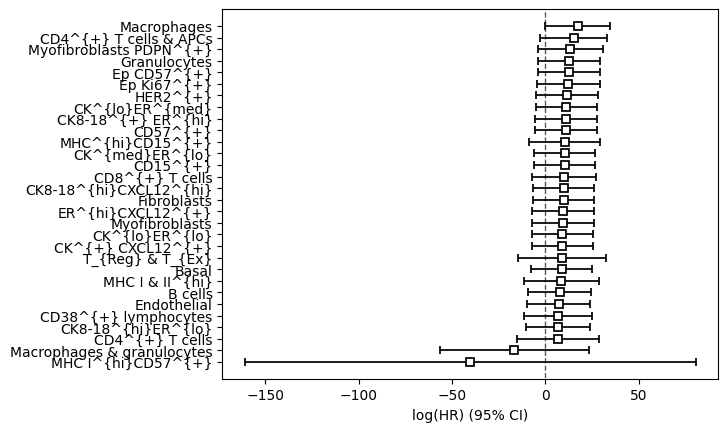

In [114]:
cph.plot();

<Axes: >

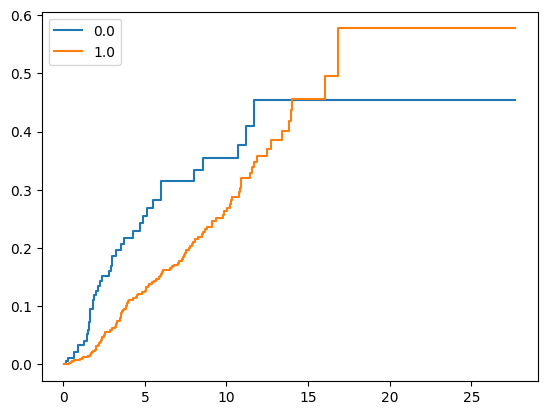

In [115]:
cph.baseline_cumulative_hazard_.plot(drawstyle="steps")

In [116]:
# cph.variance_matrix_
# cph.params_
# cph.baseline_hazard_    # 473 × 2
# cph.baseline_cumulative_hazard_  # 473 × 2
# cph._predicted_partial_hazards_
# cph.standard_errors_
# cph.confidence_intervals_
# cph.baseline_survival_   # 473 × 2
# cph.concordance_index_  # float

In [119]:
if strata is not None:
    print(df_surv.groupby(strata).size())
# there is high class imbalance, but many observations from the smallest class

ERStatus
0.0     99
1.0    395
dtype: int64


Some cell type proportions seem nearly statistically significant

### Ratio of cell type proportions

In [123]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=1)], axis=1)
# with survival data there is no pval to compute

In [127]:
# we need to clean-up data for further analyses and visualizations
# otherwise some visualization tools and ML models break with NaN and inf
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 130309 non finite values
Imputing data


In [164]:
col_exclude = []
use_data_surv = prop_types_comp_cleaned
use_cols = [x for x in use_data_surv.columns if x not in col_exclude]

drop_last_column = False   # no need here
drop_nan = True
if drop_last_column:
    df_surv = use_data_surv[use_cols].iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = use_data_surv[use_cols].join(surv[[duration_col, event_col] + covariates], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

discarded 15 / 509 observations with NaN


In [165]:
cph = CoxPHFitter() 
if strata is None:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col)
else:
    cph.fit(df_surv, duration_col=duration_col, event_col=event_col, strata=strata)
cph.print_summary()

/home/alexis/.pyenv/versions/3.10.13/envs/mosna/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['Fibroblasts FSP1^{+}', 'Ki67^{+}'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/alexis/.pyenv/versions/3.10.13/envs/mosna/lib/python3.10/site-packages/lifelines/utils/__init__.py:990: ConvergenceWarning: Your dataset has more variables than samples. Even with a penalizer (which you must use), convergence is not guaranteed.

  warnings.warn(warning_text, ConvergenceWarning)
/home/alexis/.pyenv/versions/3.10.13/envs/mosna/lib/python3.10/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CD57^{+} / MHC^{hi}CD15^{+} have very low variance when conditioned on death event present or not. This may harm convergence. This c

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

Let's see what this particular variable look like:

In [166]:
events = df_surv['DeathBreast'].astype(bool)
print(df_surv.loc[events, 'CD57^{+} / MHC^{hi}CD15^{+}'].var())
print(df_surv.loc[~events, 'CD57^{+} / MHC^{hi}CD15^{+}'].var())

# A very low variance means that the column CD57^{+} / MHC^{hi}CD15^{+} completely determines whether a subject dies or not. 

22929.199021973633
0.4162818718710582


0.15019431043077888
13.94760402179687


/tmp/ipykernel_70284/116255078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predvar['events'] = events


array([[<Axes: title={'center': 'CD57^{+} / MHC^{hi}CD15^{+}'}>]],
      dtype=object)

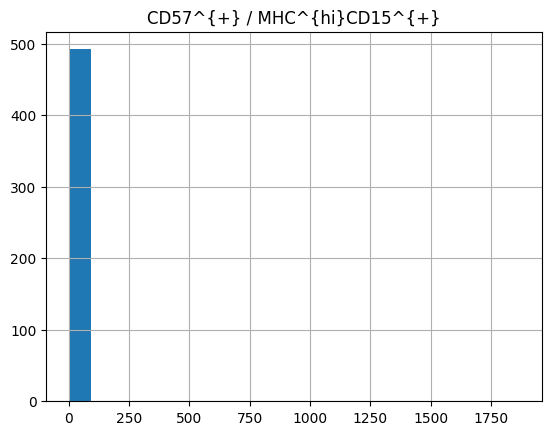

In [167]:
# dataframe of predictive variable(s)
pred_cols = ['CD57^{+} / MHC^{hi}CD15^{+}']
df_predvar = df_surv[pred_cols]
df_predvar['events'] = events
print(df_surv.loc[~events, 'CD57^{+} / MHC^{hi}CD15^{+}'].mean())
print(df_surv.loc[events, 'CD57^{+} / MHC^{hi}CD15^{+}'].mean())
df_predvar.hist(bins=20)

<Axes: ylabel='CD57^{+} / MHC^{hi}CD15^{+}'>

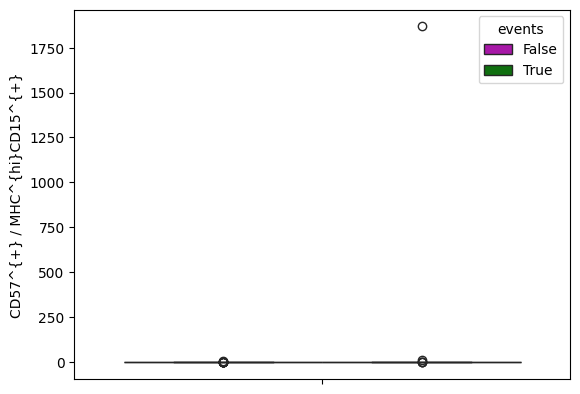

In [157]:
sns.boxplot(df_predvar, y=pred_cols[0],
            hue='events', palette=["m", "g"])

In [161]:
# use_data_surv = prop_types_comp_cleaned
use_data_surv = prop_types_comp
use_cols = [x for x in use_data_surv.columns if x not in col_exclude]

drop_last_column = False   # no need here
drop_nan = False
if drop_last_column:
    df_surv = use_data_surv[use_cols].iloc[:, :-1].join(surv[[duration_col, event_col] + covariates], how='inner')
else:
    df_surv = use_data_surv[use_cols].join(surv[[duration_col, event_col] + covariates], how='inner')
if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

In [163]:
df_surv[pred_cols].isna().sum()

CD57^{+} / MHC^{hi}CD15^{+}    415
dtype: int64

In [162]:
df_surv[pred_cols].value_counts()

CD57^{+} / MHC^{hi}CD15^{+}
0.000000                       77
1.000000                        4
0.010753                        1
0.038462                        1
0.052632                        1
0.200000                        1
0.250000                        1
0.500000                        1
0.666667                        1
2.333333                        1
2.500000                        1
4.000000                        1
9.000000                        1
13.000000                       1
1868.000000                     1
Name: count, dtype: int64

The ratios of cell types proportions can have many non finite values and can reach extreme values, we may want to not use it.

## Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

###  Assortativity and Mixing Matrix

#### Computation of assortativity

In [38]:
reload(mosna)

grouping = sample_col
n_shuffle = 500
load_dir = reconst_dir
save_dir = load_dir / "assortativity"
filename = save_dir / f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'


# reconst_dir / f'edges_patient-{patient_id}_sample-{sample}.parquet'
if RUN_LONG or not filename.exists():
    print("Computing z-scored assortativity")
    start = time()
    net_stats = mosna.groups_assort_mixmat(
        net_dir=reconst_dir, 
        attributes_col=pheno_col, 
        make_onehot=True,
        id_level_1='patient',
        id_level_2='sample', 
        extension='parquet',
        n_shuffle=n_shuffle,
        parallel_groups='max',  # or False
        save_intermediate_results=True)
    end = time()
    duration = end - start
    print(f"Assortativity took {duration:.3f}s for n_suffle {n_shuffle}")

    net_stats.index = net_stats['id']
    net_stats.drop(columns=['id'], inplace=True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net_stats.to_csv(filename)
else:
    print("Loading z-scored assortativity")
    net_stats = pd.read_csv(filename, index_col=0)

Computing z-scored assortativity
Assortativity took 9259.420s for n_suffle 500


In [42]:
net_stats

# total % B cells   % Basal % CD15^{+}  \
id                                                                  
patient-MB-0901_sample-55     2624  0.001524  0.006098   0.006479   
patient-MB-0138_sample-234     766  0.001305       NaN   0.003916   
patient-MB-0653_sample-345    2439   0.00041       NaN   0.051251   
patient-MB-0884_sample-58     2082       NaN   0.00048   0.029299   
patient-MB-0563_sample-459    1622       NaN       NaN   0.001233   
...                            ...       ...       ...        ...   
patient-MB-0246_sample-474     857       NaN       NaN        NaN   
patient-MB-2641_sample-564    1290       NaN  0.058915   0.062016   
patient-MB-0463_sample-405    1912  0.004184       NaN   0.016213   
patient-MB-0073_sample-167     552  0.007246       NaN        NaN   
patient-MB-0433_sample-400     953  0.082896       NaN   0.006296   

                           % CD38^{+} lymphocytes % CD4^{+} T cells  \
id                                                                    
patient-MB-0901_sample-55                 0.00686           0.00686   
patient-MB-0138_sample-234                    NaN          0.001305   
patient-MB-0653_sample-345                0.00492           0.00492   
patient-MB-0884_sample-58                0.000961               NaN   
patient-MB-0563_sample-459               0.002466          0.001233   
...                                           ...               ...   
patient-MB-0246_sample-474                    NaN          0.004667   
patient-MB-2641_sample-564                    NaN          0.000775   
patient-MB-0463_sample-405               0.001569          0.021967   
patient-MB-0073_sample-167               0.003623          0.057971   
patient-MB-0433_sample-400                    NaN          0.023085   

                           % CD4^{+} T cells & APCs % CD8^{+} T cells  \
id                                                                      
patient-MB-0901_sample-55                  0.005335          0.019817   
patient-MB-0138_sample-234                      NaN          0.018277   
patient-MB-0653_sample-345                  0.01394           0.00492   
patient-MB-0884_sample-58                  0.000961           0.00048   
patient-MB-0563_sample-459                      NaN               NaN   
...                                             ...               ...   
patient-MB-0246_sample-474                      NaN          0.009335   
patient-MB-2641_sample-564                      NaN          0.016279   
patient-MB-0463_sample-405                  0.01046          0.033996   
patient-MB-0073_sample-167                 0.101449          0.063406   
patient-MB-0433_sample-400                 0.005247          0.084995   

                           % CK8-18^{hi}CXCL12^{hi} % CK8-18^{hi}ER^{lo}  ...  \
id                                                                        ...   
patient-MB-0901_sample-55                  0.000381             0.000381  ...   
patient-MB-0138_sample-234                  0.01436                  NaN  ...   
patient-MB-0653_sample-345                  0.03567              0.00615  ...   
patient-MB-0884_sample-58                  0.528818             0.001921  ...   
patient-MB-0563_sample-459                 0.151048             0.017879  ...   
...                                             ...                  ...  ...   
patient-MB-0246_sample-474                 0.101517                  NaN  ...   
patient-MB-2641_sample-564                 0.093023                  NaN  ...   
patient-MB-0463_sample-405                 0.327929             0.000523  ...   
patient-MB-0073_sample-167                      NaN                  NaN  ...   
patient-MB-0433_sample-400                 0.044071             0.001049  ...   

                           MHC I^{hi}CD57^{+} - Granulocytes STD  \
id                                                                 
patient-MB-0901_sample-55                                    NaN 

#### Example of Mixing Matrix

In [43]:
sample_id = 'patient-MB-0901_sample-55'
# TODO: reimplement the 'RAW' flag
# raw_cols = [x for x in net_stats.columns if x.endswith('RAW') and not x.startswith('assort')]
# raw_cols = net_stats.iloc[:, 26:257].columns
z_cols = [x for x in net_stats.columns if x.endswith('Z') and not x.startswith('assort')]

# mixmat_raw = mosna.series_to_mixmat(net_stats.loc[sample_id, raw_cols], discard=' RAW').astype(float)
mixmat_z = mosna.series_to_mixmat(net_stats.loc[sample_id, z_cols], discard=' Z').astype(float)
# assort_raw = net_stats.loc[sample_id, "assort"]
assort_z = net_stats.loc[sample_id, "assort Z"]

# select_cols = np.logical_and(mixmat_raw.isna(axis=0) == 0, mixmat_z.isna(axis=0) == 0)

Z-scored assortativity by cell types: 22.49


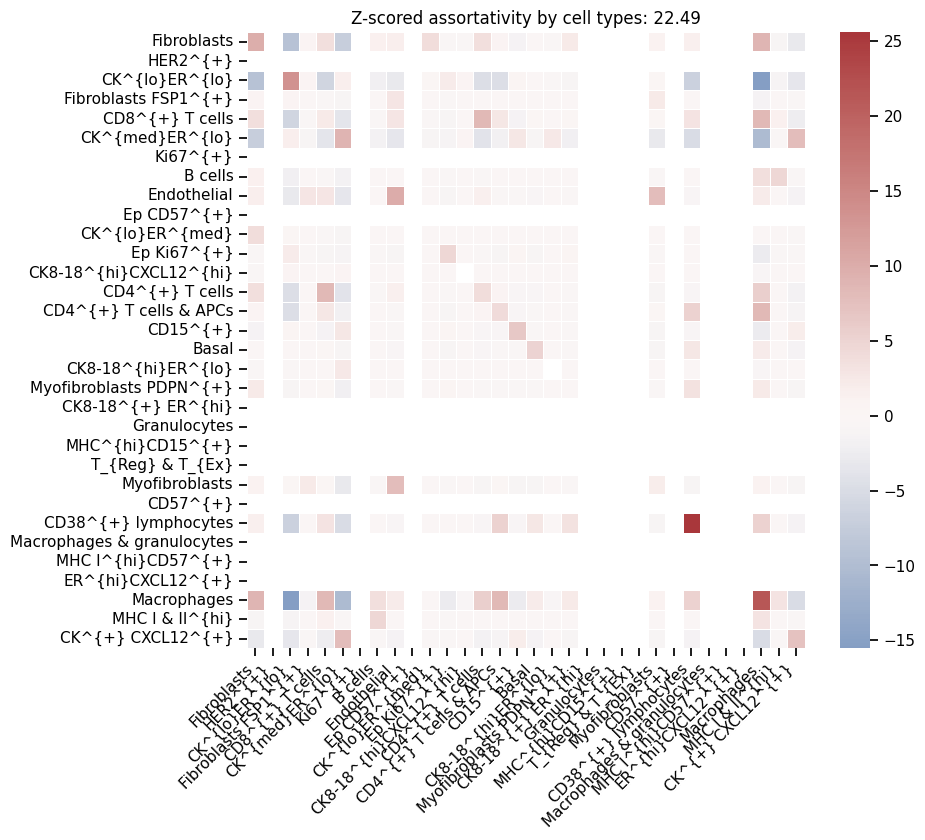

In [48]:
# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

# title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
# print(title)
# f, ax = plt.subplots(figsize=figsize)
# sns.heatmap(mixmat_raw, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
# ax.set_title(title)
# plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right');
# # plt.xticks(rotation=30, ha='right', fontsize=20);
# # plt.yticks(fontsize=20);
# plt.savefig(save_dir / f"assortativity_raw_sample-{sample_id}", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=45, ha='right');
plt.savefig(save_dir / "assortativity_z-scored_sample-{sample_id}", bbox_inches='tight', facecolor='white')

Z-scored assortativity by cell types: 22.49


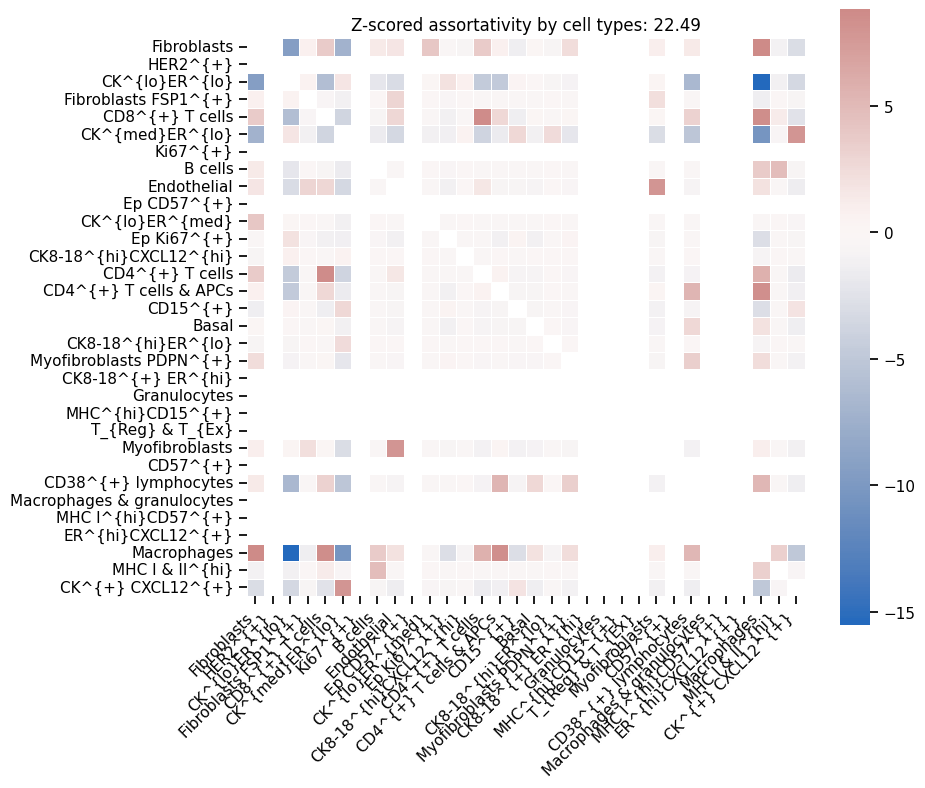

In [49]:
# Hide diagonal

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(mixmat_raw, dtype=bool))

# Generate a mask for the diagonal
mask = np.eye(mixmat_z.shape[0], dtype=bool)

# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

# title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
# print(title)
# f, ax = plt.subplots(figsize=figsize)
# sns.heatmap(mixmat_raw, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
# ax.set_title(title)
# plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right');#, fontsize=20);
# # plt.yticks(fontsize=20);
# plt.savefig(save_dir / f"assortativity_raw_sample-{sample_id}_diagonal", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=45, ha='right');
plt.savefig(save_dir / "assortativity_z-scored_sample-{sample_id}_diagonal", bbox_inches='tight', facecolor='white')

#### Assortativity and patients survival

In [128]:
z_cols = [x for x in net_stats.columns if x.endswith('Z')]
z_net_stats = net_stats[z_cols].astype(float)

##### Per sample

In [120]:
z_net_stats

assort Z  B cells - B cells Z  Basal - B cells Z  \
id                                                                              
patient-MB-0901_sample-55   22.485595            -0.104923          -0.393727   
patient-MB-0138_sample-234  17.495634                  NaN                NaN   
patient-MB-0653_sample-345  16.543879                  NaN                NaN   
patient-MB-0884_sample-58   24.571628                  NaN                NaN   
patient-MB-0563_sample-459  13.096669                  NaN                NaN   
...                               ...                  ...                ...   
patient-MB-0246_sample-474  19.529642                  NaN                NaN   
patient-MB-2641_sample-564  39.369450                  NaN                NaN   
patient-MB-0463_sample-405  35.744433            -0.333276                NaN   
patient-MB-0073_sample-167   3.937874             4.105745                NaN   
patient-MB-0433_sample-400  26.293788            14.043690                NaN   

                            Basal - Basal Z  CD15^{+} - B cells Z  \
id                                                                  
patient-MB-0901_sample-55          5.126832             -0.349927   
patient-MB-0138_sample-234              NaN             -0.169725   
patient-MB-0653_sample-345              NaN             -0.606083   
patient-MB-0884_sample-58               NaN                   NaN   
patient-MB-0563_sample-459              NaN                   NaN   
...                                     ...                   ...   
patient-MB-0246_sample-474              NaN                   NaN   
patient-MB-2641_sample-564        28.342888                   NaN   
patient-MB-0463_sample-405              NaN             -0.826531   
patient-MB-0073_sample-167              NaN                   NaN   
patient-MB-0433_sample-400              NaN             -1.689885   

                            CD15^{+} - Basal Z  CD15^{+} - CD15^{+} Z  \
id                                                                      
patient-MB-0901_sample-55            -0.741826               6.452761   
patient-MB-0138_sample-234                 NaN              -0.127515   
patient-MB-0653_sample-345                 NaN              13.179753   
patient-MB-0884_sample-58             2.002981              27.918132   
patient-MB-0563_sample-459                 NaN              11.135529   
...                                        ...                    ...   
patient-MB-0246_sample-474                 NaN                    NaN   
patient-MB-2641_sample-564            7.961255              21.401058   
patient-MB-0463_sample-405                 NaN               3.526131   
patient-MB-0073_sample-167                 NaN                    NaN   
patient-MB-0433_sample-400                 NaN              -0.284154   

                            CD38^{+} lymphocytes - B cells Z  \
id                                                             
patient-MB-0901_sample-55                          -0.413762   
patient-MB-0138_sample-234                               NaN   
patient-MB-0653_sample-345                         -0.181818   
patient-MB-0884_sample-58                                NaN   
patient-MB-0563_sample-459                               NaN   
...                                                      ...   
patient-MB-0246_sample-474                               NaN   
patient-MB-2641_sample-564                               NaN   
patient-MB-0463_sample-405                          3.763907   
patient-MB-0073_sample-167                         -0.263230   
patient-MB-0433_sample-400                               NaN   

                            CD38^{+} lymphocytes - Basal Z  \
id                                                           
patient-MB-0901_sample-55                         2.648033   
patient-MB-0138_sample-234                             NaN   
patient-MB-0653_sample-345                    

In [121]:
# Have a look at nan values
for name, value in z_net_stats.isna().sum(axis=0).items():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   363
Basal - B cells Z                                     440
Basal - Basal Z                                       410
CD15^{+} - B cells Z                                  468
CD15^{+} - Basal Z                                    468
CD15^{+} - CD15^{+} Z                                 390
CD38^{+} lymphocytes - B cells Z                      409
CD38^{+} lymphocytes - Basal Z                        492
CD38^{+} lymphocytes - CD15^{+} Z                     512
CD38^{+} lymphocytes - CD38^{+} lymphocytes Z         442
CD4^{+} T cells - B cells Z                           268
CD4^{+} T cells - Basal Z                             360
CD4^{+} T cells - CD15^{+} Z                          385
CD4^{+} T cells - CD38^{+} lymphocytes Z              369
CD4^{+} T cells - CD4^{+} T cells Z                   189
CD4^{+} T cells & APCs - B cells Z                    396
CD4^{+} T cells 

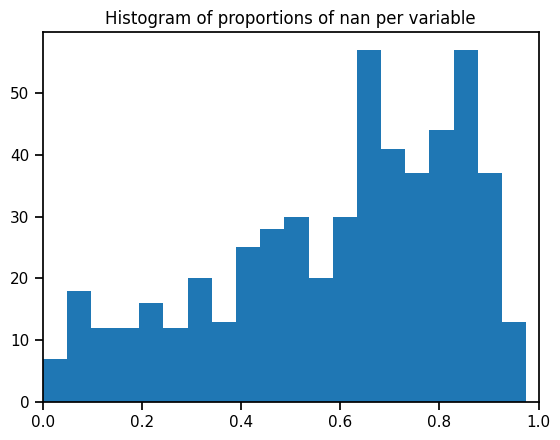

In [122]:
plt.hist(z_net_stats.isna().sum(axis=0) / z_net_stats.shape[0], bins=20);
plt.xlim([0, 1])
plt.title('Histogram of proportions of nan per variable');

Many levels of interaction between cell types have non finite values.

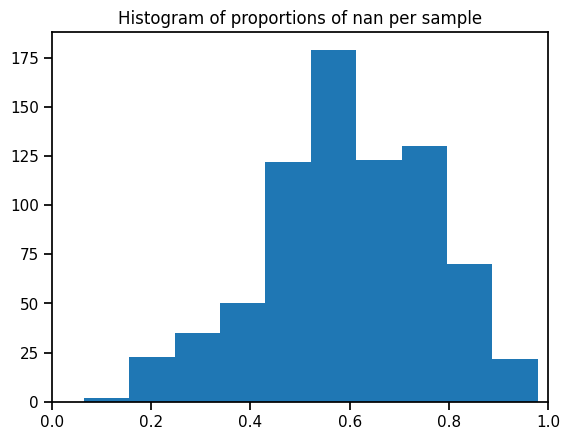

In [123]:
plt.hist(z_net_stats.isna().sum(axis=1) / z_net_stats.shape[1]);
plt.xlim([0, 1])
plt.title('Histogram of proportions of nan per sample');

Many generated columns have a high proportion of nan.  
mosna can clean data by discarding variables with the highest proportion of nan, and then impute (guess) missing data with a KNNImputer. However for best accuracy, we prefer to first *drop* columns with too many nan, relatively aggressively, then drop observations (samples) much less aggressively (clinical data is precious!), then impute data. 

Before dropping variables z_net_stats shape: (756, 529)
There are 238085 non finite values
Final z_net_stats shape: (756, 112)
There are 417 variables discarded


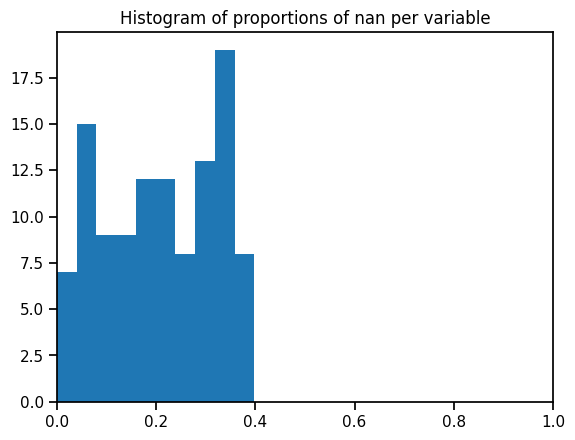

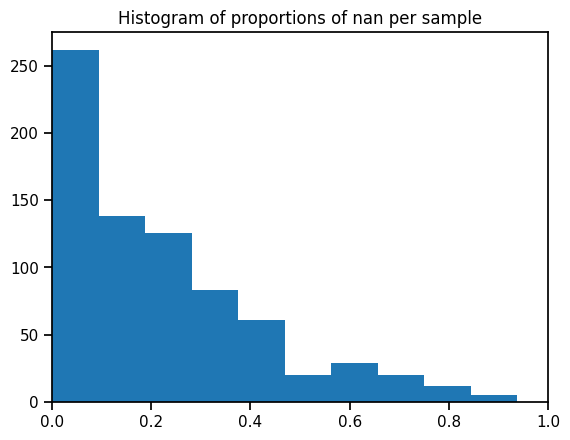

In [129]:
reload(mosna)

print("Before dropping variables z_net_stats shape:", z_net_stats.shape)

# drop columns
z_net_stats, select_finite = mosna.clean_data(
    z_net_stats, 
    method='drop',
    thresh=0.4,
    axis=0,
    )
print("Final z_net_stats shape:", z_net_stats.shape)
unselected = ~select_finite
print(f"There are {unselected.sum()} variables discarded")

plt.hist(z_net_stats.isna().sum(axis=0) / z_net_stats.shape[0]);
plt.xlim([0, 1])
plt.title('Histogram of proportions of nan per variable');
plt.figure()
plt.hist(z_net_stats.isna().sum(axis=1) / z_net_stats.shape[1]);
plt.xlim([0, 1])
plt.title('Histogram of proportions of nan per sample');

Before dropping samples z_net_stats shape: (756, 112)
There are 17704 non finite values
Final z_net_stats shape: (747, 112)
There are 9 observations discarded


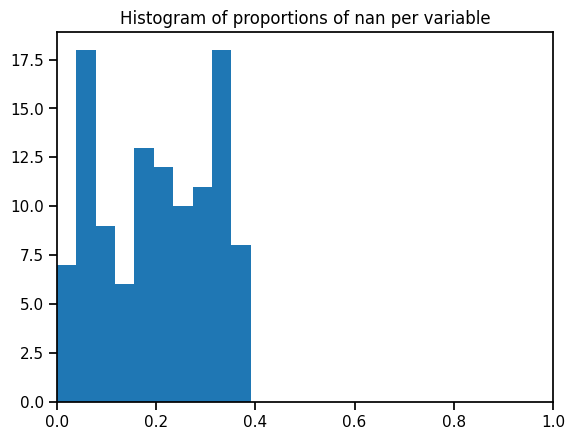

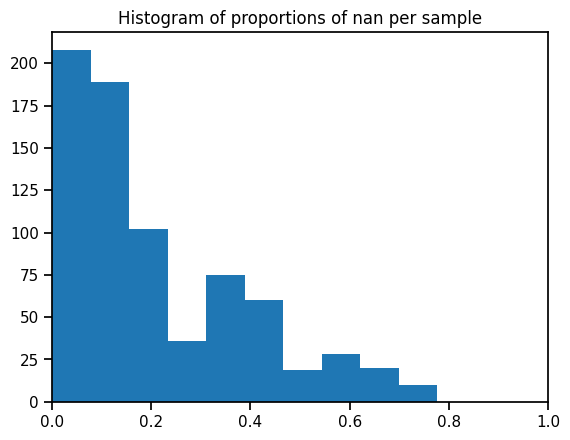

In [130]:
print("Before dropping samples z_net_stats shape:", z_net_stats.shape)

# drop samples
z_net_stats, select_finite = mosna.clean_data(
    z_net_stats, 
    method='drop',
    thresh=0.8,
    axis=1,
    )
print("Final z_net_stats shape:", z_net_stats.shape)
unselected = ~select_finite
print(f"There are {unselected.sum()} observations discarded")

plt.hist(z_net_stats.isna().sum(axis=0) / z_net_stats.shape[0]);
plt.xlim([0, 1])
plt.title('Histogram of proportions of nan per variable');
plt.figure()
plt.hist(z_net_stats.isna().sum(axis=1) / z_net_stats.shape[1]);
plt.xlim([0, 1])
plt.title('Histogram of proportions of nan per sample');

In [188]:
# impute non finite values in data for further analyses and visualizations
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='mixed',
    thresh=0.8,
    )
print("Final z_net_stats shape:", z_net_stats_cleaned.shape)

There are 16837 non finite values (20.1%)
Imputing data
Final z_net_stats shape: (747, 112)


In [189]:
# Add back patient id to the network stats dataframe
def parse_patient(s):
    return s.split('_')[0][8:]

if patient_col not in z_net_stats_cleaned.columns:
    z_net_stats_cleaned[patient_col] = [parse_patient(s) for s in z_net_stats_cleaned.index]

# Add back sample id to the network stats dataframe
def parse_sample(s):
    return s.split('_')[1][7:]

if sample_col not in z_net_stats_cleaned.columns:
    z_net_stats_cleaned[sample_col] = [parse_sample(s) for s in z_net_stats_cleaned.index]

In [190]:
duration_col = 'yearsToStatus'
event_col = 'DeathBreast'
covariates = ['ERStatus'] #, 'ERBB2_pos'] # else []
strata = 'ERStatus'

status = surv[[duration_col, event_col] + covariates]
status

yearsToStatus  DeathBreast ERStatus
metabric_id                                     
MB-0000          11.540041            0      1.0
MB-0002           6.951403            0      1.0
MB-0005          13.445585            1      1.0
MB-0006          13.546886            0      1.0
MB-0010           0.640657            1      1.0
...                    ...          ...      ...
MB-3688           2.179329            1      1.0
MB-3692           5.089665            1      1.0
MB-3747          18.877481            0      1.0
MB-3804          18.754278            0      0.0
MB-3876           1.612594            1      0.0

[509 rows x 3 columns]

In [193]:
drop_nan = True

df_surv = z_net_stats_cleaned.merge(status, how='inner', on=patient_col)

if drop_nan:
    n_obs_orig = len(df_surv)
    df_surv.dropna(axis=0, inplace=True)
    n_obs = len(df_surv)
    if n_obs != n_obs_orig:
        print(f'discarded {n_obs_orig - n_obs} / {n_obs_orig} observations with NaN')

discarded 15 / 571 observations with NaN


In [196]:
non_pred_cols = [patient_col, sample_col]
pred_cols = [x for x in df_surv if x not in non_pred_cols]

In [197]:
cph = CoxPHFitter(penalizer=0.0001)
if strata is None:
    cph.fit(df_surv[pred_cols], duration_col=duration_col, event_col=event_col)
else:
    cph.fit(df_surv[pred_cols], duration_col=duration_col, event_col=event_col, strata=strata)

# if convergence fails, use CoxPHFitter(penalizer=0.1).fit(…)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 556 total observations, 385 right-censored observations>
             duration col = 'yearsToStatus'
                event col = 'DeathBreast'
                penalizer = 0.0001
                 l1 ratio = 0.0
                   strata = ERStatus
      baseline estimation = breslow
   number of observations = 556
number of events observed = 171
   partial log-likelihood = -823.62
         time fit was run = 2024-02-29 10:02:20 UTC

---
                                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                            
assort Z                                             0.00      1.00      0.02           -0.03            0.03                0.97                1.03
CD4^{+} T cells - B cells Z                         -0.03      0.97      0.06           -0.15            0.10                0.86                1.10
CD4^{+} T cells - CD4^{+} T cells Z                 -0.03      0.97      0.05           -0.12            0.07                0.89                1.07
CD8^{+} T cells - B cells Z                         -0.02      0.98      0.05           -0.11            0.08                0.89                1.08
CD8^{+} T cells - CD4^{+} T cells Z                 -0.03      0.97      0.05           -0.12            0.06                0.89                1.06
CD8^{+} T cells - CD8^{+} T cells Z                  0.03      1.03      0.04           -0.06            0.11                0.94                1.12
CK8-18^{hi}CXCL12^{hi} - CD4^{+} T cells Z          -0.16      0.85      0.14           -0.44            0.12                0.64                1.13
CK8-18^{hi}CXCL12^{hi} - CD8^{+} T cells Z          -0.04      0.96      0.09           -0.21            0.13                0.81                1.14
CK8-18^{hi}CXCL12^{hi} - CK8-18^{hi}CXCL12^{hi} Z   -0.01      0.99      0.03           -0.06            0.05                0.94                1.05
CK^{+} CXCL12^{+} - CD4^{+} T cells Z                0.17      1.18      0.10           -0.03            0.36                0.97                1.44
CK^{+} CXCL12^{+} - CD8^{+} T cells Z               -0.10      0.90      0.09           -0.28            0.08                0.76                1.08
CK^{+} CXCL12^{+} - CK8-18^{hi}CXCL12^{hi} Z        -0.09      0.91      0.04           -0.17           -0.01                0.84                0.99
CK^{+} CXCL12^{+} - CK^{+} CXCL12^{+} Z              0.02      1.02      0.03           -0.04            0.09                0.96                1.10
CK^{lo}ER^{lo} - B cells Z                           0.07      1.07      0.07           -0.08            0.21                0.92                1.24
CK^{lo}ER^{lo} - CD4^{+} T cells Z                   0.03      1.03      0.09           -0.15            0.20                0.86                1.22
CK^{lo}ER^{lo} - CD8^{+} T cells Z                  -0.06      0.94      0.08           -0.22            0.10                0.81                1.10
CK^{lo}ER^{lo} - CK8-18^{hi}CXCL12^{hi} Z            0.01      1.01      0.07           -0.12            0.14                0.88                1.15
CK^{lo}ER^{lo} - CK^{+} CXCL12^{+} Z                 0.06      1.06      0.06           -0.05            0.17                0.95                1.19
CK^{lo}ER^{lo} - CK^{lo}ER^{lo} Z                    0.01      1.01      0.04           -0.05            0.08                0.95                1.09
CK^{med}ER^{lo} - B cells Z                          0.01      1.01      0.07           -0.13            0.14                0.88                1.15
CK^{med}ER^{lo} - CD4^{+} T cells Z                 -0.07      0.93      0.09           -0.24            0.10                0.78                1.10
CK^{med}ER^{lo} - CD8^{+} T cells Z                  0.12      1.12      0

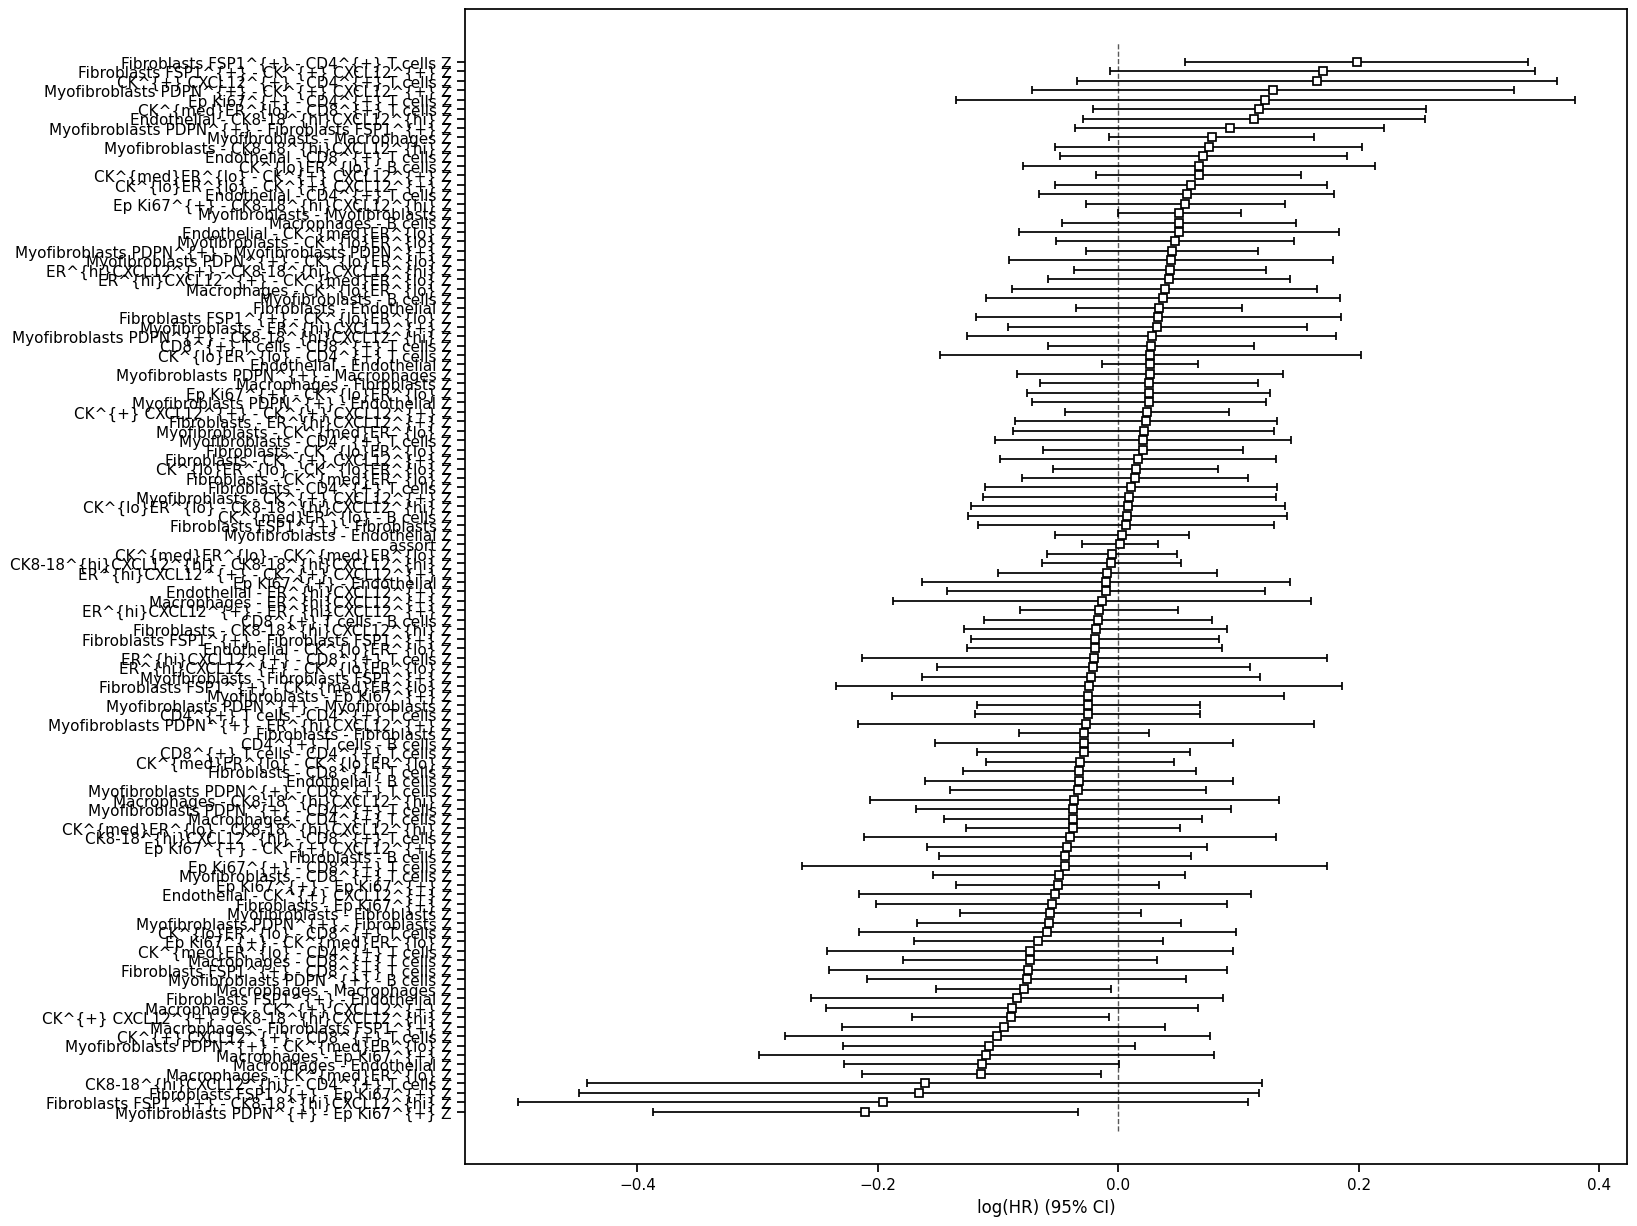

In [205]:
ax = cph.plot();
ax.get_figure().set_size_inches(15, 15);

##### Per patient